# Exercise 3: Time series with ARIMA

## Do not start the exercise until you fully understand the submission guidelines.


* The homework assignments are executed automatically. 
* Failure to comply with the following instructions will result in a significant penalty. 
* Appeals regarding your failure to read these instructions will be denied. 
* Kind reminder: the homework assignments contribute 60% of the final grade.


## Read the following instructions carefully:

1. This Jupyter notebook contains all the step-by-step instructions needed for this exercise.
1. Write **efficient**, **vectorized** code whenever possible. Some calculations in this exercise may take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deductions.
1. You are responsible for the correctness of your code and should add as many tests as you see fit to this jupyter notebook. Tests will not be graded nor checked.
1. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/).
1. Your code must run without errors. Use at least `numpy` 1.15.4. Any code that cannot run will not be graded.
1. Write your own code. Cheating will not be tolerated.
1. Submission includes a zip file that contains this notebook, with your ID as the file name. For example, `hw1_123456789_987654321.zip` if you submitted in pairs and `hw1_123456789.zip` if you submitted the exercise alone. The name of the notebook should follow the same structure.
   
Please use only a **zip** file in your submission.

---
---

## Please sign that you have read and understood the instructions: 

316492776
318900016

---
---


In [ ]:
!pip3 install statsmodels
!pip3 install seaborn
!pip3 install numpy
!pip3 install pandas
!pip3 install tqdm
!pip3 install scikit-learn
!pip3 install yfinance

In [567]:
# Import necessary libraries
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics import tsaplots
import numpy as np
import seaborn as sns
import itertools
from matplotlib.colors import ListedColormap
from numpy import log
from sklearn.datasets import load_iris, make_classification
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from tqdm.auto import tqdm
import pandas as pd
import yfinance as yf

sns.set_theme()
np.random.seed(42)

# Design your algorithm
Make sure to describe the algorithm, its limitations, and describe use-cases.

# Your implementations
You may add new cells, write helper functions or test code as you see fit.
Please use the cell below and include a description of your implementation.
Explain code design consideration, algorithmic choices and any other details you think is relevant to understanding your implementation.
Failing to explain your code will lead to point deductions.

In [568]:
class ArimaCustom: ## Change it to Arima algorithm
    def __init__(self, T: int = 50, verbose: bool = True):
        self.T = T
        self.alphas = []
        self.estimators_ = []  # to match with sklearn so functions can work on both
        self.verbose = verbose

    def fit(self, X: np.ndarray, y: np.ndarray):
        w = np.ones_like(y) / len(y)
        for t in tqdm(range(self.T), disable=not self.verbose, desc="t"):
            if self.verbose:
                print(f"After {t} models, Z=loss(H)={self.Z(X,y)}")
            h = DecisionTreeClassifier(max_depth=1)
            h.fit(X=X, y=y, sample_weight=w)
            epsilon = (w * (h.predict(X=X) != y)).sum()
            if epsilon >= 0.5:
                if self.verbose:
                    print(f"Stopping eraly! h is not better than random. {epsilon=}")
                return self
            alpha = 0.5 * (np.log(1 - epsilon) - np.log(epsilon))
            # update alphas, models and w
            self.estimators_.append(h)
            self.alphas.append(alpha)
            w *= np.exp(-alpha * h.predict(X) * y)
            w /= 2 * (epsilon * (1 - epsilon)) ** 0.5
        return self

    def H(self, X: np.ndarray) -> np.ndarray:
        return np.array(
            [
                alpha * model.predict(X)
                for alpha, model in zip(self.alphas, self.estimators_)
            ]
        ).sum(axis=0)

    def Z(self, X: np.ndarray, y: np.ndarray) -> float:
        return np.exp(-y * self.H(X)).sum()

    def predict(self, X: np.ndarray) -> np.ndarray:
        predictions = np.sign(self.H(X))
        return predictions

# Generate data
Please use the cell below to discuss your dataset choice and why it is appropriate (or not) for this algorithm.

For the data generation. We chose to use the IRIS dataset
The IRIS Flower dataset is a well known dataset that works well with boosting algorithms, easy to classify and it contains 4 features:
1. Sepal length
2. Sepal width
3. Petal length
4. Petal width

And 3 classes (labels): Setosa, Versicolor, Virginica that marked as 0, 1, 2

For sampling our implementation, we disabled one of the classes of IRIS in order to handle a binary-labeled dataset

In [569]:
path = './sample_dataset.csv'

sample_dataset = pd.read_csv(path)

sample_dataset.head()

date     value
0  1991-07-01  3.526591
1  1991-08-01  3.180891
2  1991-09-01  3.252221
3  1991-10-01  3.611003
4  1991-11-01  3.565869

In [570]:
date_filter = sample_dataset['date'].loc[df['date'].str.endswith('01-01')]
date_filter

Series([], Name: date, dtype: object)

In [571]:
result = adfuller(sample_dataset.value.dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: 3.145185689306743
p-value: 1.0


In [572]:
def plot_acf(values, title):
    plt.rcParams.update({'figure.figsize':(20, 5), 'figure.dpi':120})

    # Create subplot for ACF
    fig, axes = plt.subplots(1, 1, sharex=True)
    # Original Series ACF
    axes.plot(values)
    axes.set_title(title)

    # Create subplot for ACF
    fig, axes = plt.subplots(1, 2, sharex=True)
    tsaplots.plot_acf(values, ax=axes[0])
    tsaplots.plot_pacf(values, ax=axes[1])
    
    # 1st Differencing ACF
    fig, axes = plt.subplots(1, 1, sharex=True)
    axes.plot(values.diff())
    axes.set_title(f'{title} - 1st Order Differencing')

    # Create subplot for ACF
    fig, axes = plt.subplots(1, 2, sharex=True)
    tsaplots.plot_acf(values.diff().dropna(), ax=axes[0])
    tsaplots.plot_pacf(values.diff().dropna(), ax=axes[1])

    
    # 2nd Differencing ACF
    fig, axes = plt.subplots(1, 1, sharex=True)
    axes.plot(values.diff().diff())
    axes.set_title(f'{title} - 2nd Order Differencing')
    
    # Create subplot for ACF
    fig, axes = plt.subplots(1, 2, sharex=True)
    tsaplots.plot_acf(values.diff().diff().dropna(), ax=axes[0])
    tsaplots.plot_pacf(values.diff().diff().dropna(), ax=axes[1])
    
    plt.show()

# Arima demonstration 
Demonstrate your Arima implementation.

Add plots and figures. 

Please use the cell below to describe your results and tests.

Describe the difference between your implementation and the statsmodels implementation. Hint: you can look at the documentation.

In order to demonstrate our result, we chose to use the following comparisons:
1. Comparison between the methods:
   * We made a comparison between the SKLearn Model and the Custom Model, while comparing the true labels / predicted labels of each one of the models using a confusion matrix, and also compare between their accuracies (In the bottom of the notebook, a comparison of all our experiments)
   * The accuracies are compared both for train set and both for test set
   * Since IRIS dataset is a well known dataset exact for these models, we've found a very high accuracy for both models
3. Comparison between the features:
   * The IRIS dataset has 4 features, and we compared the accuracy between all the possible feature pairs
   * Also, we built a boundry graph for each one of the pairs (A boundry graph can be built just for 2 features)
   * We found that the best combination are when one feature is Sepal and the other is Petal

In [573]:
def run_arima(dataset, param, date_label):
    print("Training based on:")
    for k, v in param.items():
        print(f"{k} -> {v}")
        
    model = ARIMA(dataset.value, order=param["order"])
    model_fit = model.fit()
    print(model_fit.summary())

    plt.rcParams.update({'figure.figsize':(20, 5), 'figure.dpi':120})
    residuals = pd.DataFrame(model_fit.resid)
    fig, ax = plt.subplots(1,2)
    residuals.plot(title="Residuals", ax=ax[0])
    residuals.plot(kind='kde', title='Density', ax=ax[1])
    plt.show()

    forecast = model_fit.predict()
    forecast_df = pd.DataFrame({'date':dataset['date'], 'value':forecast.values})
    print(type(forecast))
    plt.plot(list(dataset['date']), list(forecast), label = "forecast")
    plt.plot(list(dataset['date']), list(dataset['value']), label = "actual")
    plt.xticks(date_label, rotation=30)
    plt.legend()
    plt.title('Actual vs forecast')
    plt.show()

    return forecast_df

In [574]:
def run_arima_train_test(dataset, param, date_label):
    print("Train / Test based on:")

    split = int(len(dataset)*param["train_rate"])
    train_dataset = dataset[:split]
    test_dataset = dataset[split:]
    
    for k, v in param.items():
        print(f"{k} -> {v}")
    model = ARIMA(train_dataset.value, order=param["order"])
    model_fit = model.fit()
    print(model_fit.summary())

    plt.rcParams.update({'figure.figsize':(20, 5), 'figure.dpi':120})
    residuals = pd.DataFrame(model_fit.resid)
    fig, ax = plt.subplots(1,2)
    residuals.plot(title="Residuals", ax=ax[0])
    residuals.plot(kind='kde', title='Density', ax=ax[1])
    plt.show()

    forecast = model_fit.get_forecast(len(dataset) - split, alpha=0.05)  # 95% conf
    forecast_df = pd.DataFrame({'date':test_dataset['date'], 'value': forecast.predicted_mean})
    #print(type(forecast))
    plt.plot(list(train_dataset['date']), list(train_dataset['value']), label = "training")
    plt.plot(list(test_dataset['date']), list(test_dataset['value']), label = "actual")
    plt.plot(list(forecast_df['date']), list(forecast_df['value']), label = "forecast")
    plt.fill_between(list(forecast_df['date']), 
                 forecast.conf_int().iloc[:, 0], 
                 forecast.conf_int().iloc[:, 1], 
                 color='k', alpha=.15)
    plt.xticks(date_label, rotation=30)
    plt.legend()
    plt.title('Training / Actual vs forecast')
    plt.show()

    return forecast_df

ACF / PACF of original data


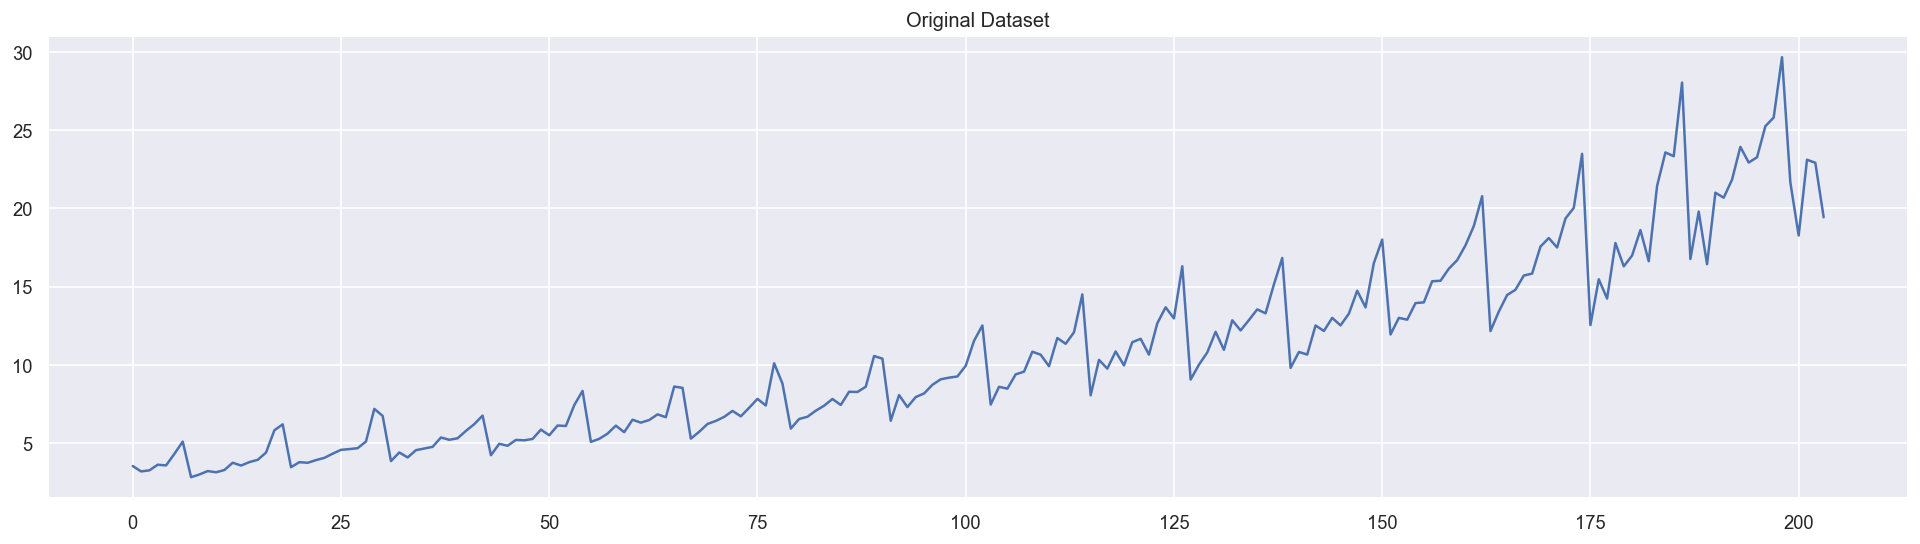

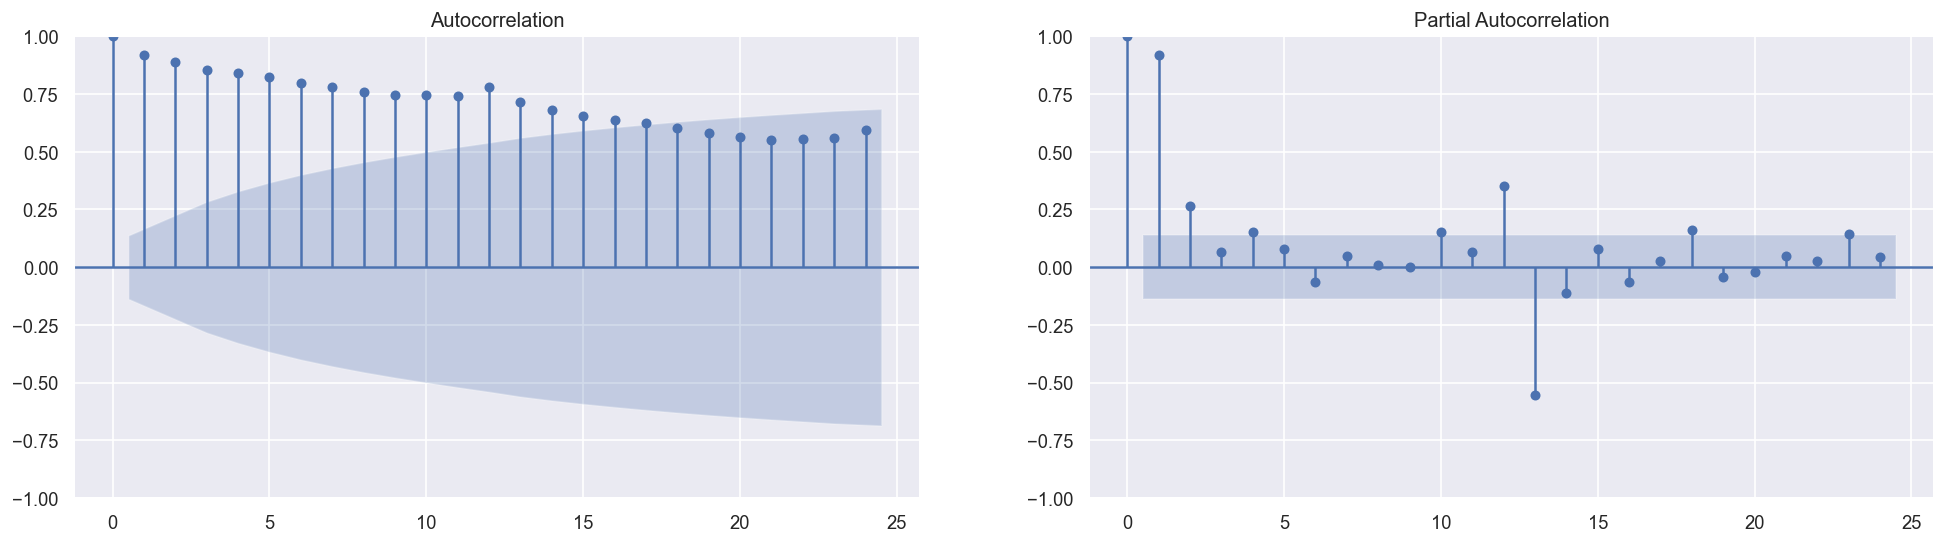

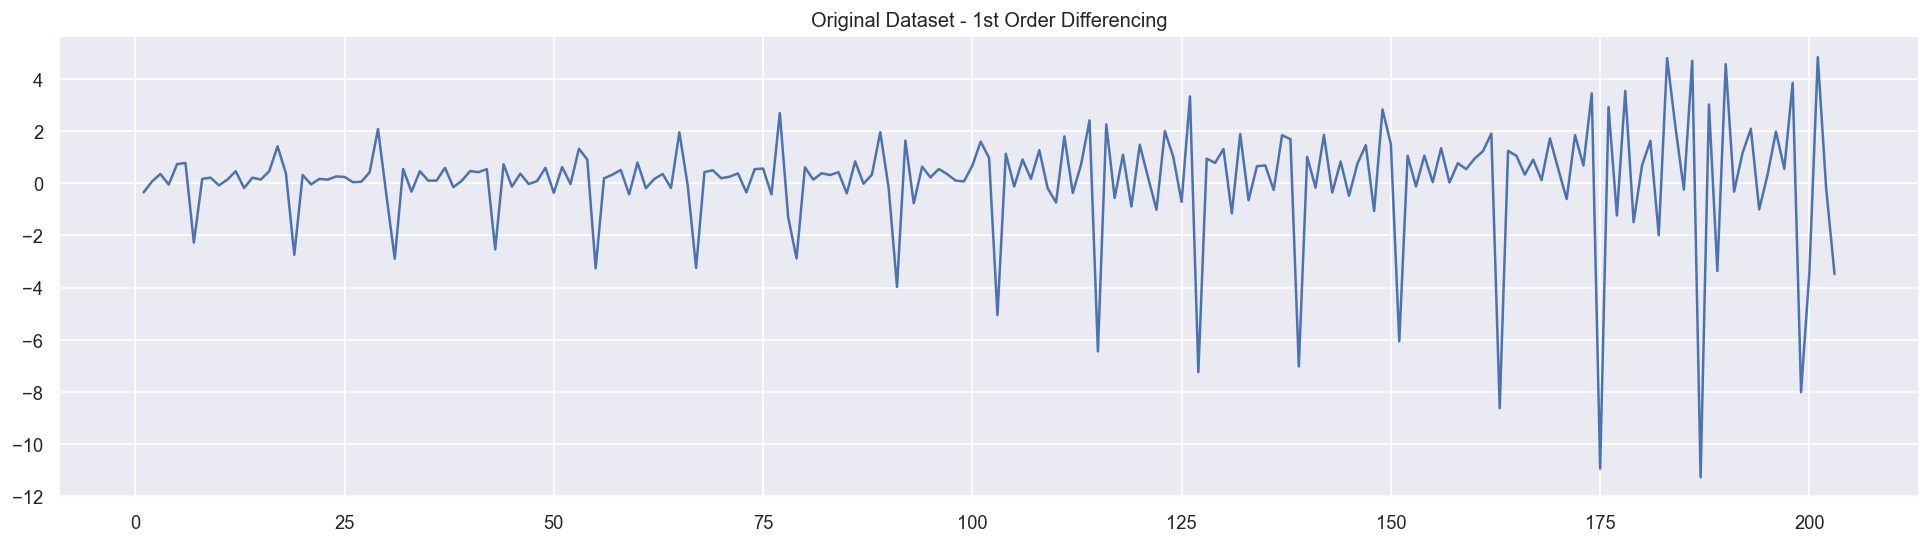

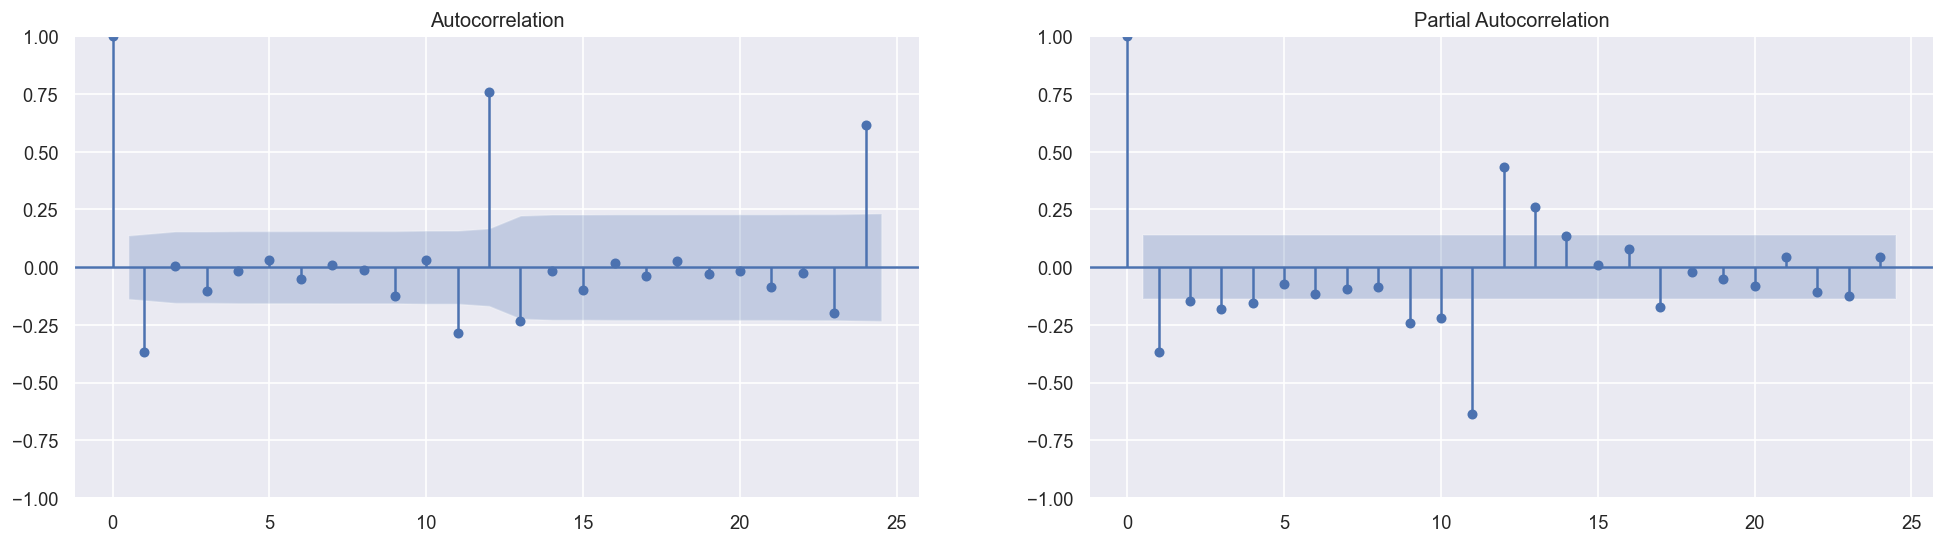

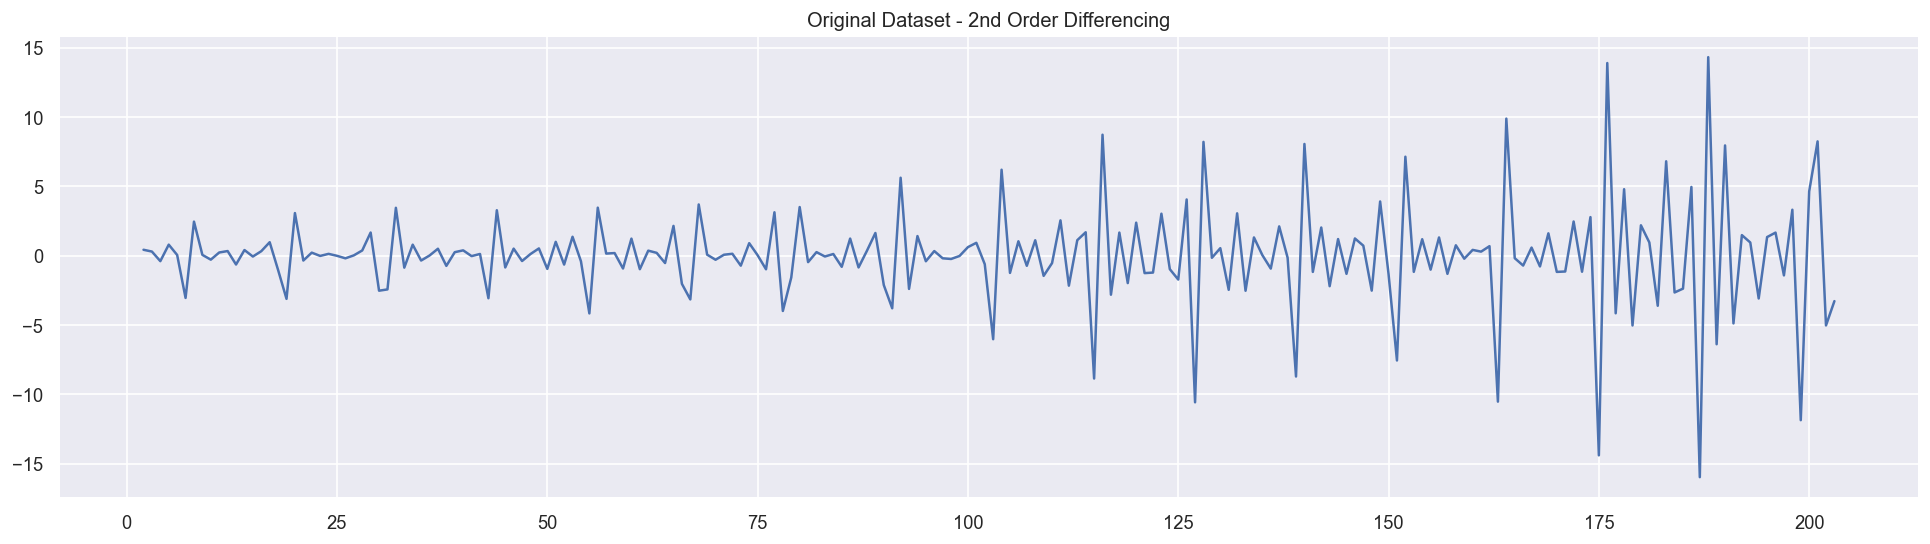

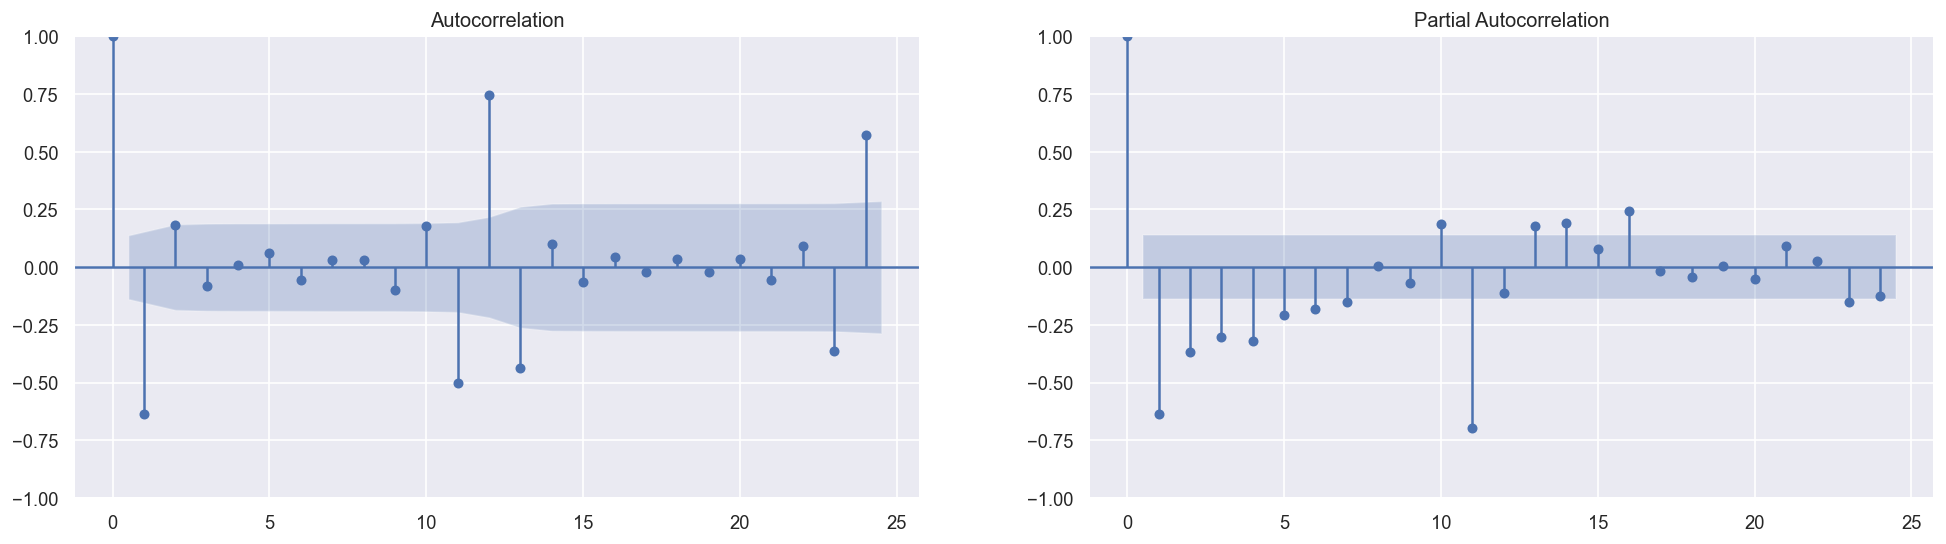

6      1992-01-01
18     1993-01-01
30     1994-01-01
42     1995-01-01
54     1996-01-01
66     1997-01-01
78     1998-01-01
90     1999-01-01
102    2000-01-01
114    2001-01-01
126    2002-01-01
138    2003-01-01
150    2004-01-01
162    2005-01-01
174    2006-01-01
186    2007-01-01
198    2008-01-01
Name: date, dtype: object
Training based on:
order -> (3, 2, 1)
train_rate -> 0.7
                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  204
Model:                 ARIMA(3, 2, 1)   Log Likelihood                -432.842
Date:                Sun, 09 Mar 2025   AIC                            875.683
Time:                        00:27:14   BIC                            892.225
Sample:                             0   HQIC                           882.376
                                - 204                                         
Covariance Type:                  opg                      

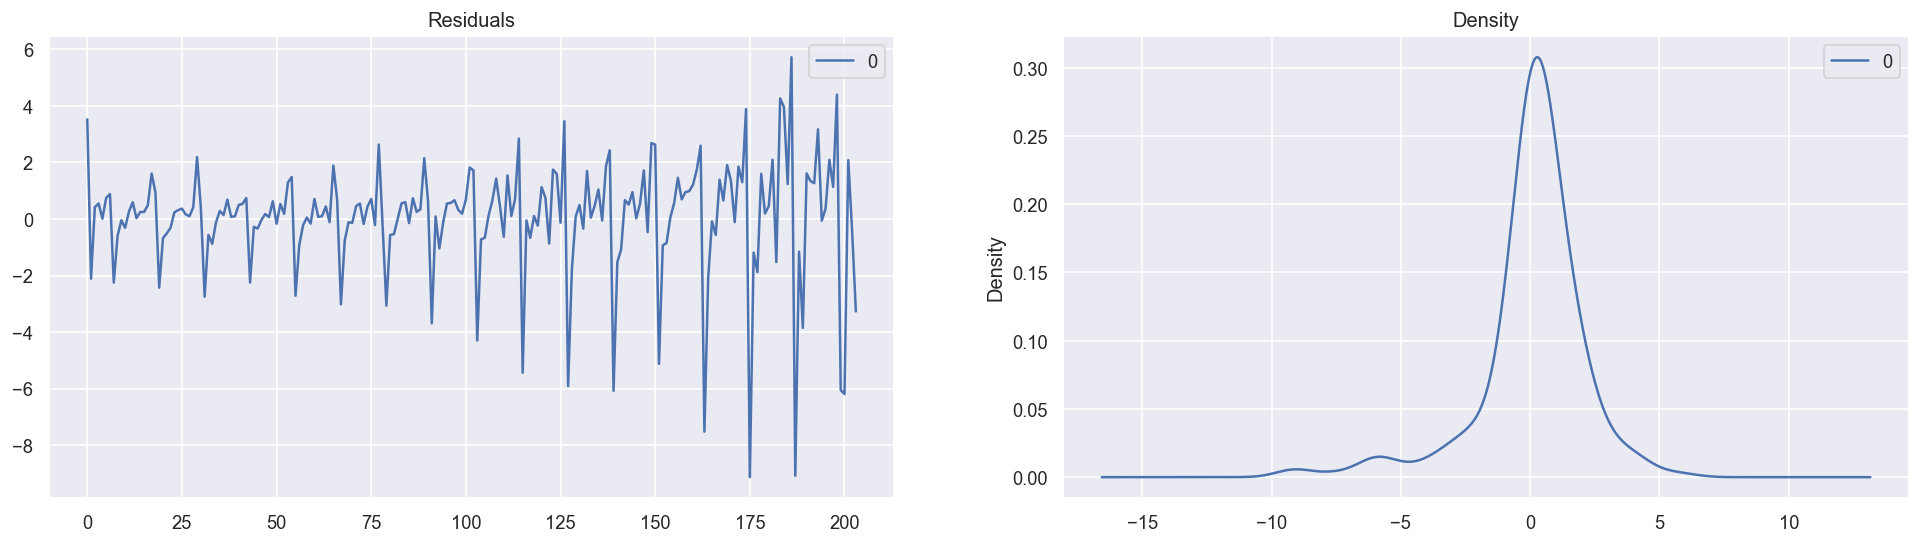

<class 'pandas.core.series.Series'>


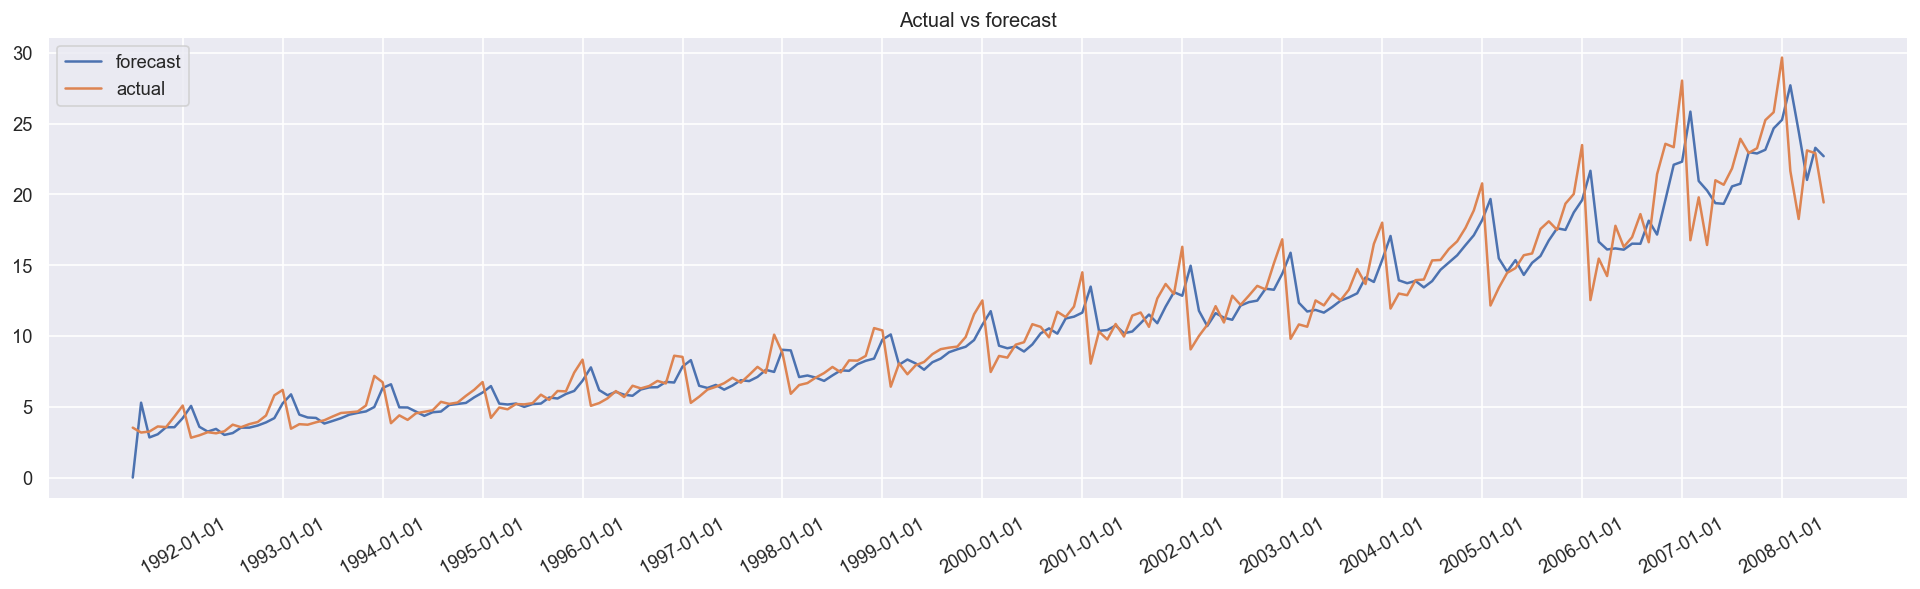

Train / Test based on:
order -> (3, 2, 1)
train_rate -> 0.7
                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  142
Model:                 ARIMA(3, 2, 1)   Log Likelihood                -251.244
Date:                Sun, 09 Mar 2025   AIC                            512.488
Time:                        00:27:15   BIC                            527.196
Sample:                             0   HQIC                           518.465
                                - 142                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4418      0.124     -3.558      0.000      -0.685      -0.198
ar.L2         -0.2762      0.123     -2.254      0.024      -0.516     

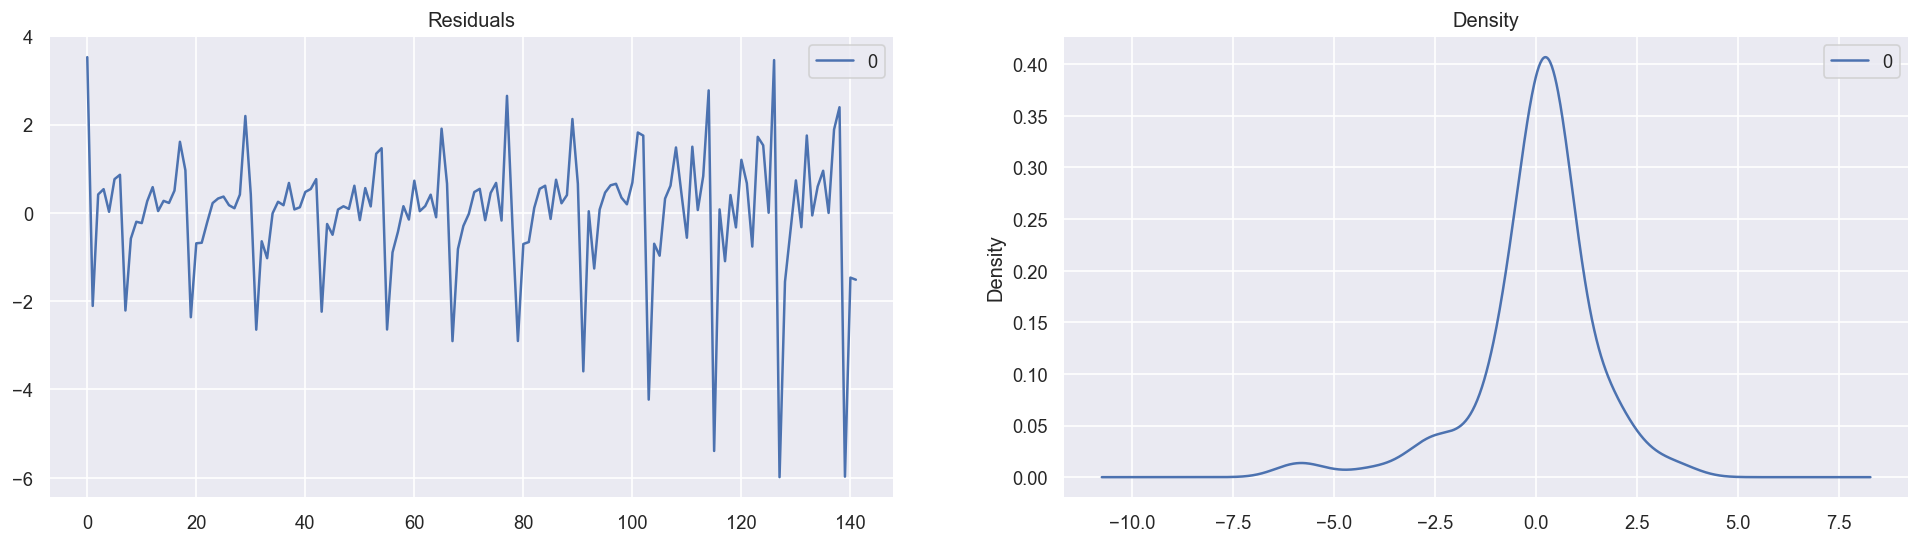

/Users/scohen6/projects/.venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


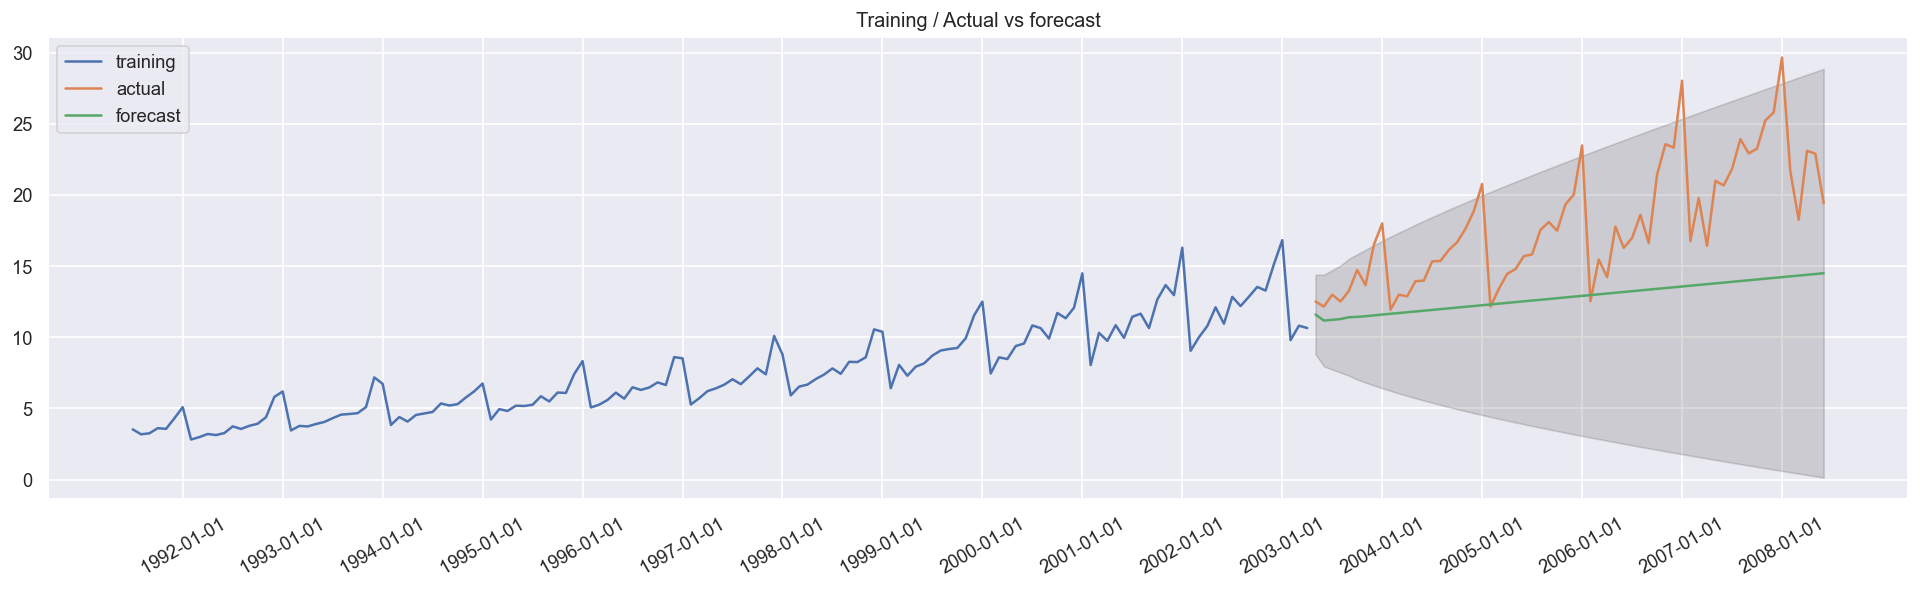

Training based on:
order -> (1, 1, 2)
train_rate -> 0.7
                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  204
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -424.570
Date:                Sun, 09 Mar 2025   AIC                            857.140
Time:                        00:27:15   BIC                            870.393
Sample:                             0   HQIC                           862.502
                                - 204                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4178      0.356      1.174      0.240      -0.280       1.115
ma.L1         -0.9546      0.377     -2.531      0.011      -1.694      -0.

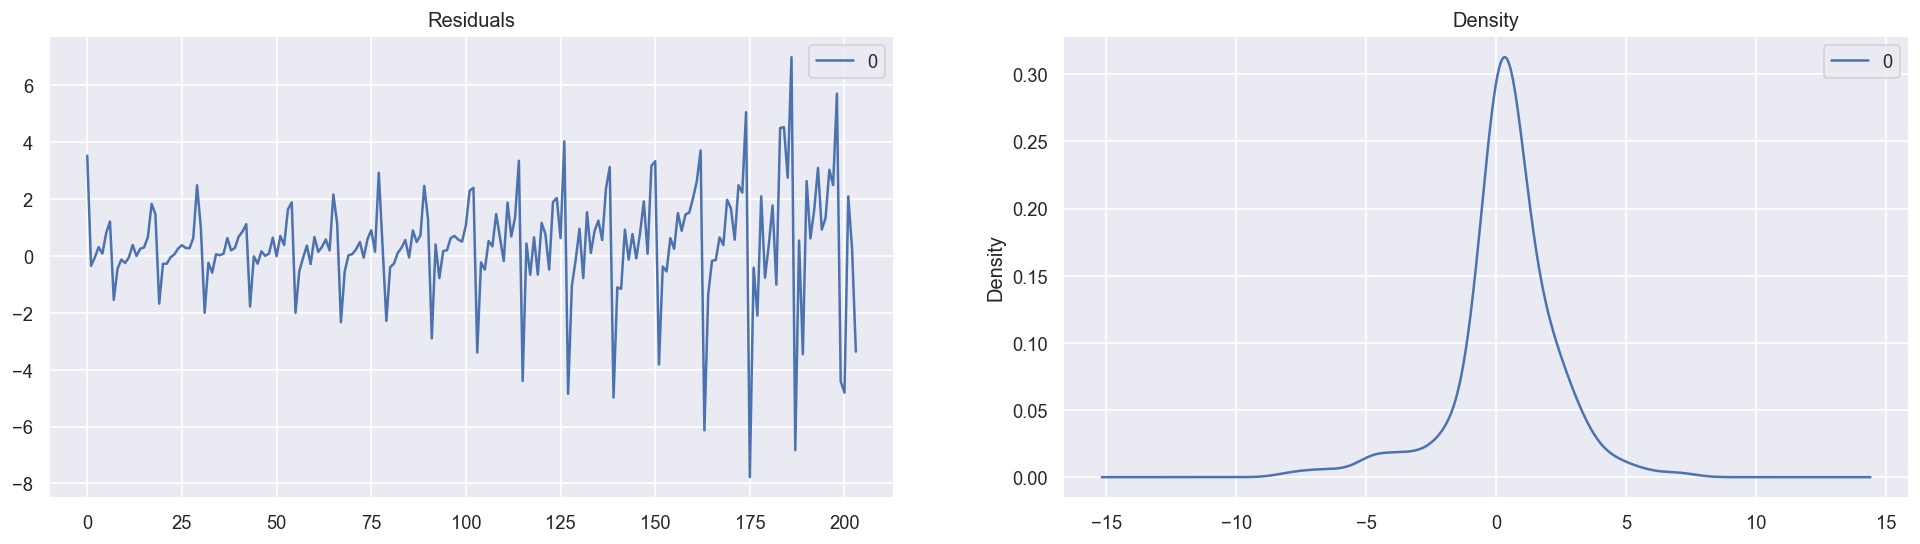

<class 'pandas.core.series.Series'>


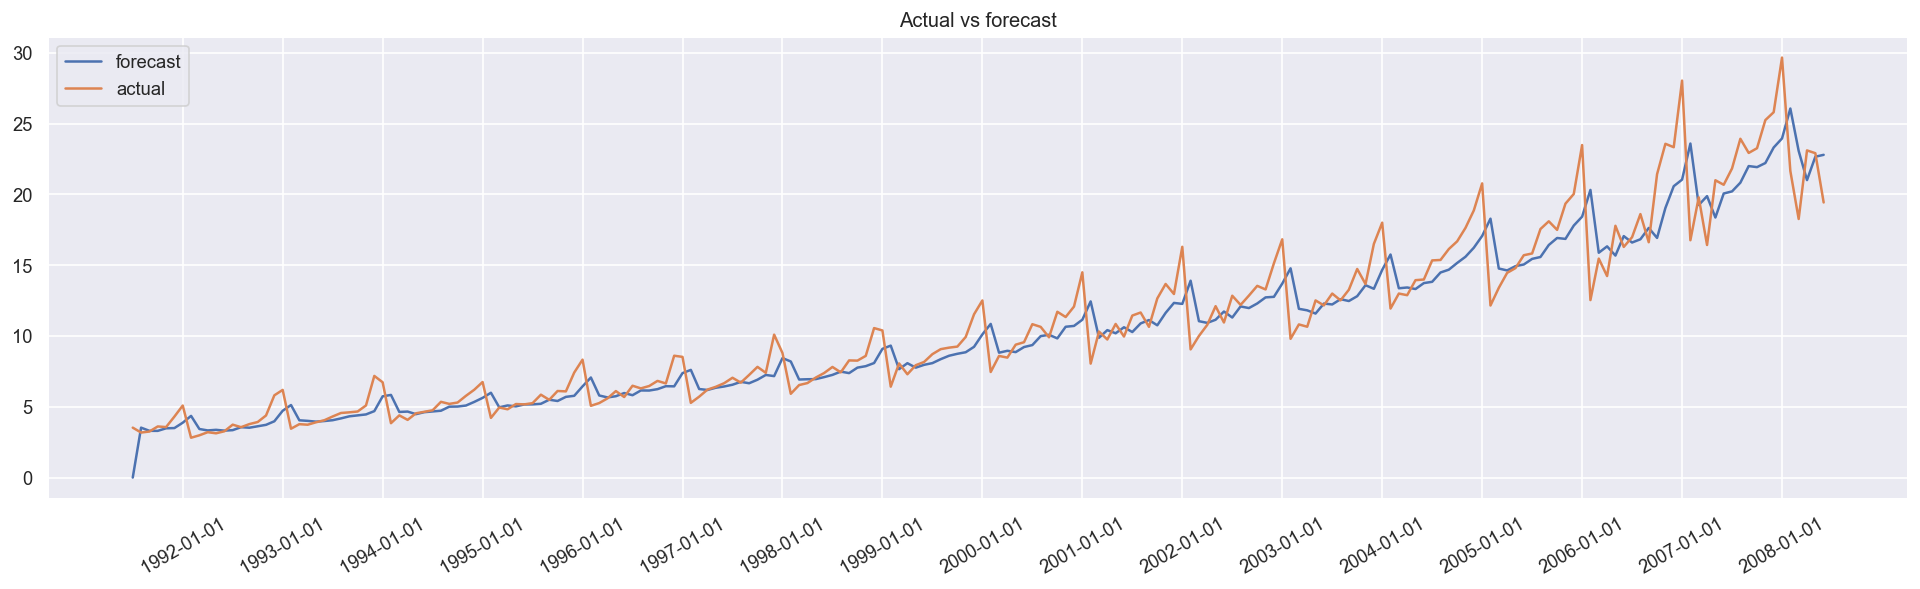

Train / Test based on:
order -> (1, 1, 2)
train_rate -> 0.7
                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  142
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -242.893
Date:                Sun, 09 Mar 2025   AIC                            493.786
Time:                        00:27:15   BIC                            505.581
Sample:                             0   HQIC                           498.579
                                - 142                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2453      0.591      0.415      0.678      -0.914       1.404
ma.L1         -0.8013      0.569     -1.408      0.159      -1.917     

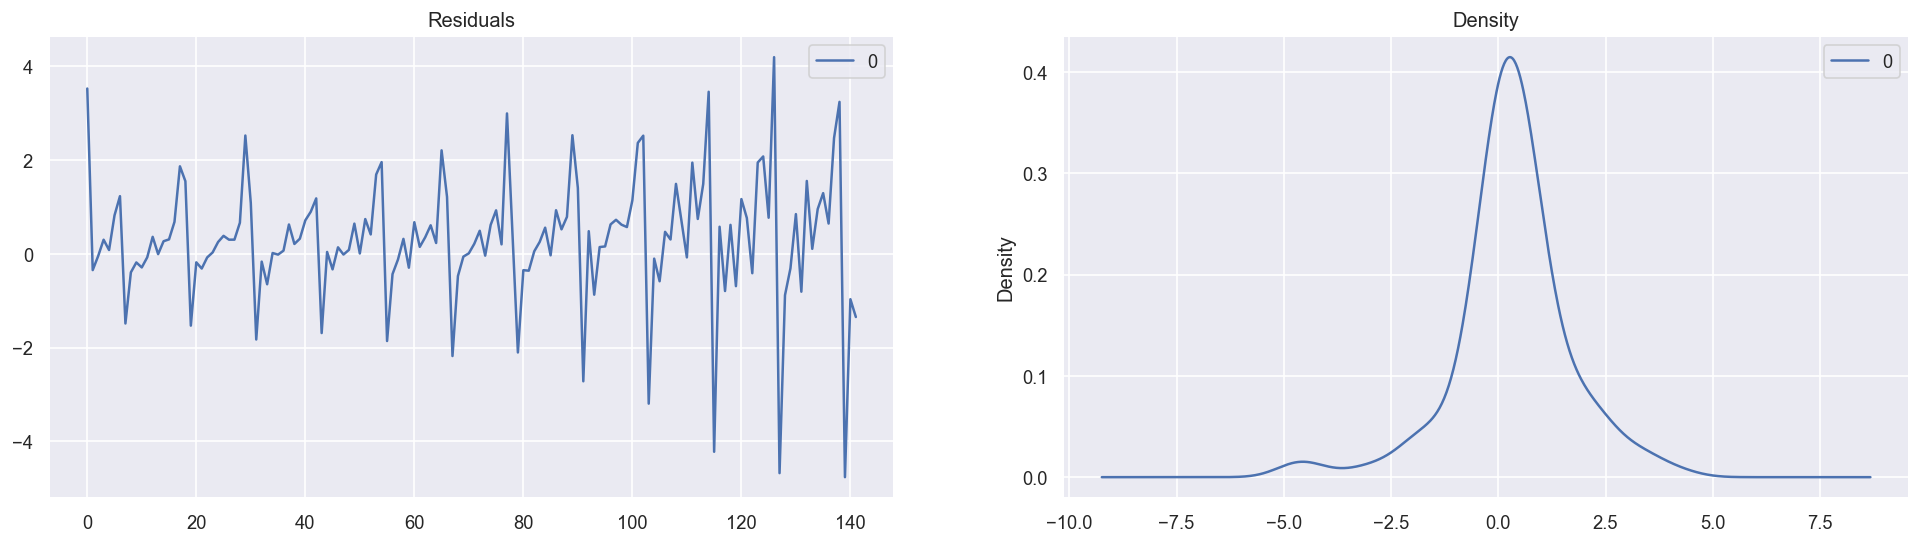

/Users/scohen6/projects/.venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


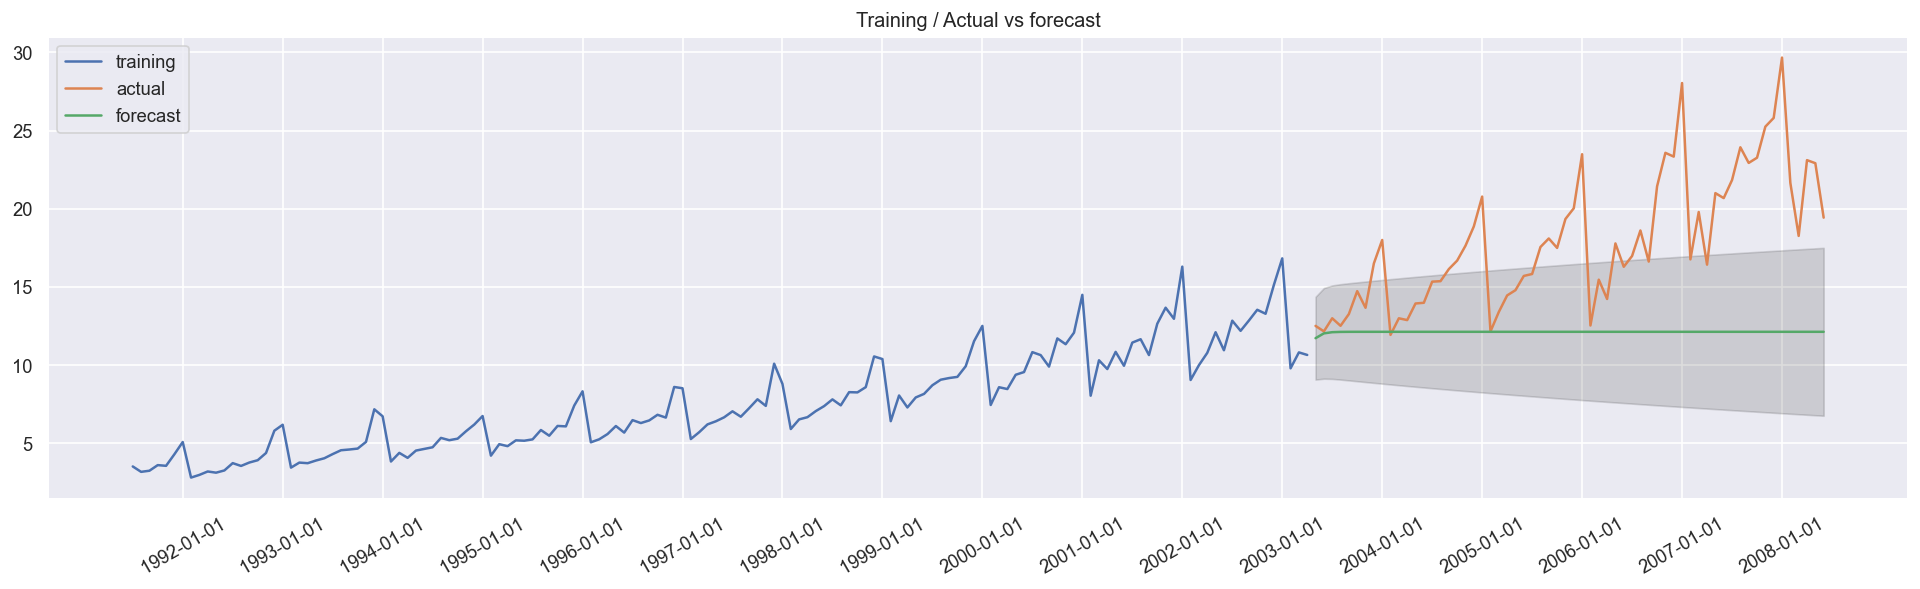

Training based on:
order -> (1, 1, 1)
train_rate -> 0.7
                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  204
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -424.762
Date:                Sun, 09 Mar 2025   AIC                            855.524
Time:                        00:27:16   BIC                            865.463
Sample:                             0   HQIC                           859.545
                                - 204                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3009      0.094      3.195      0.001       0.116       0.485
ma.L1         -0.8300      0.048    -17.204      0.000      -0.925      -0.

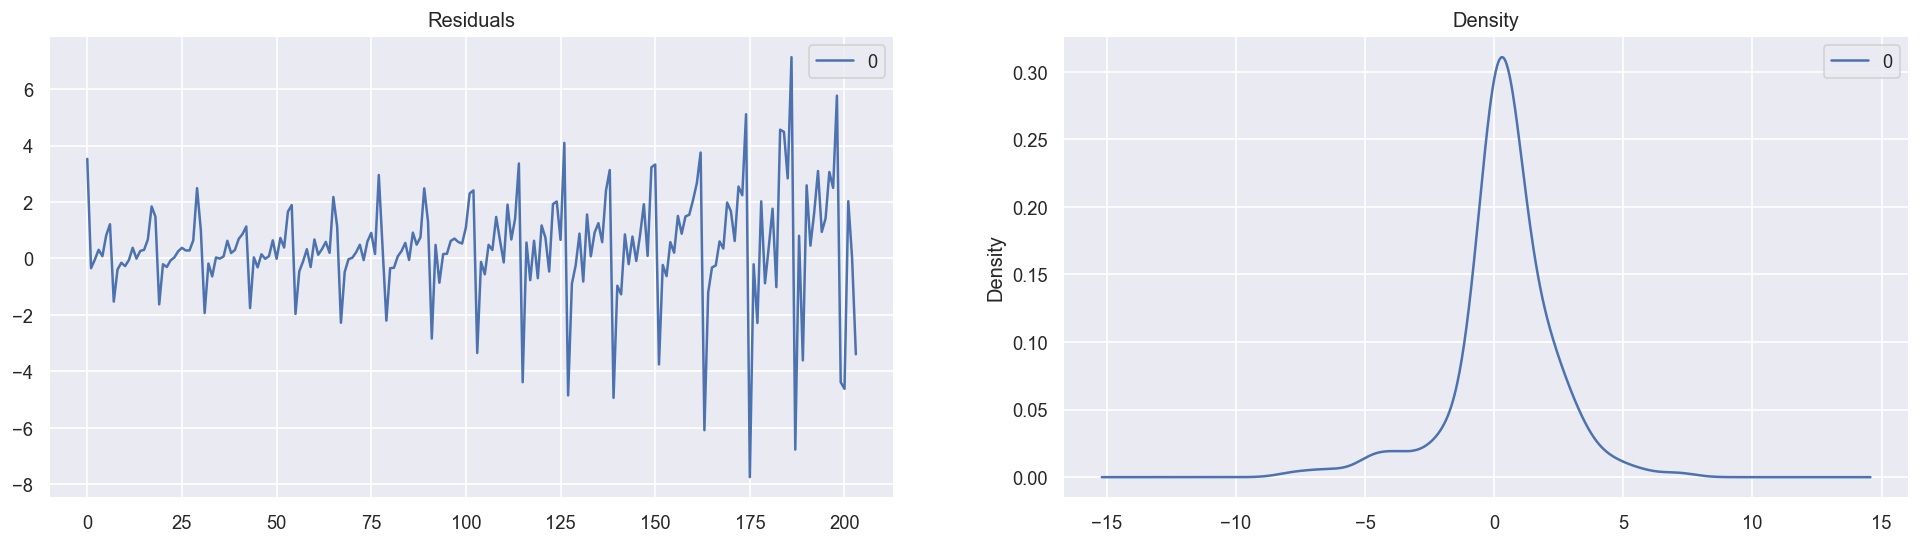

<class 'pandas.core.series.Series'>


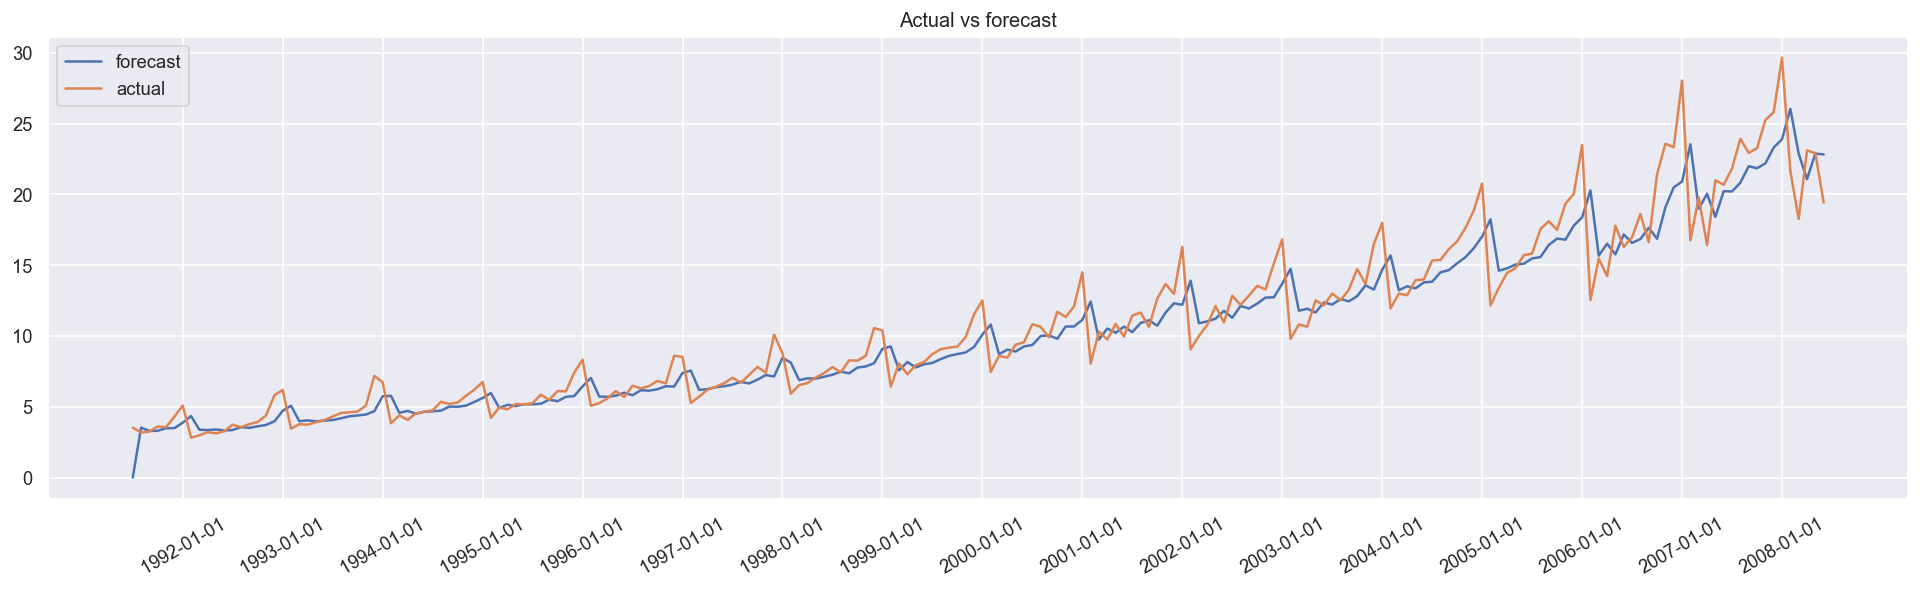

Train / Test based on:
order -> (1, 1, 1)
train_rate -> 0.7
                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  142
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -242.904
Date:                Sun, 09 Mar 2025   AIC                            491.808
Time:                        00:27:16   BIC                            500.654
Sample:                             0   HQIC                           495.402
                                - 142                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2844      0.185      1.539      0.124      -0.078       0.647
ma.L1         -0.8431      0.089     -9.435      0.000      -1.018     

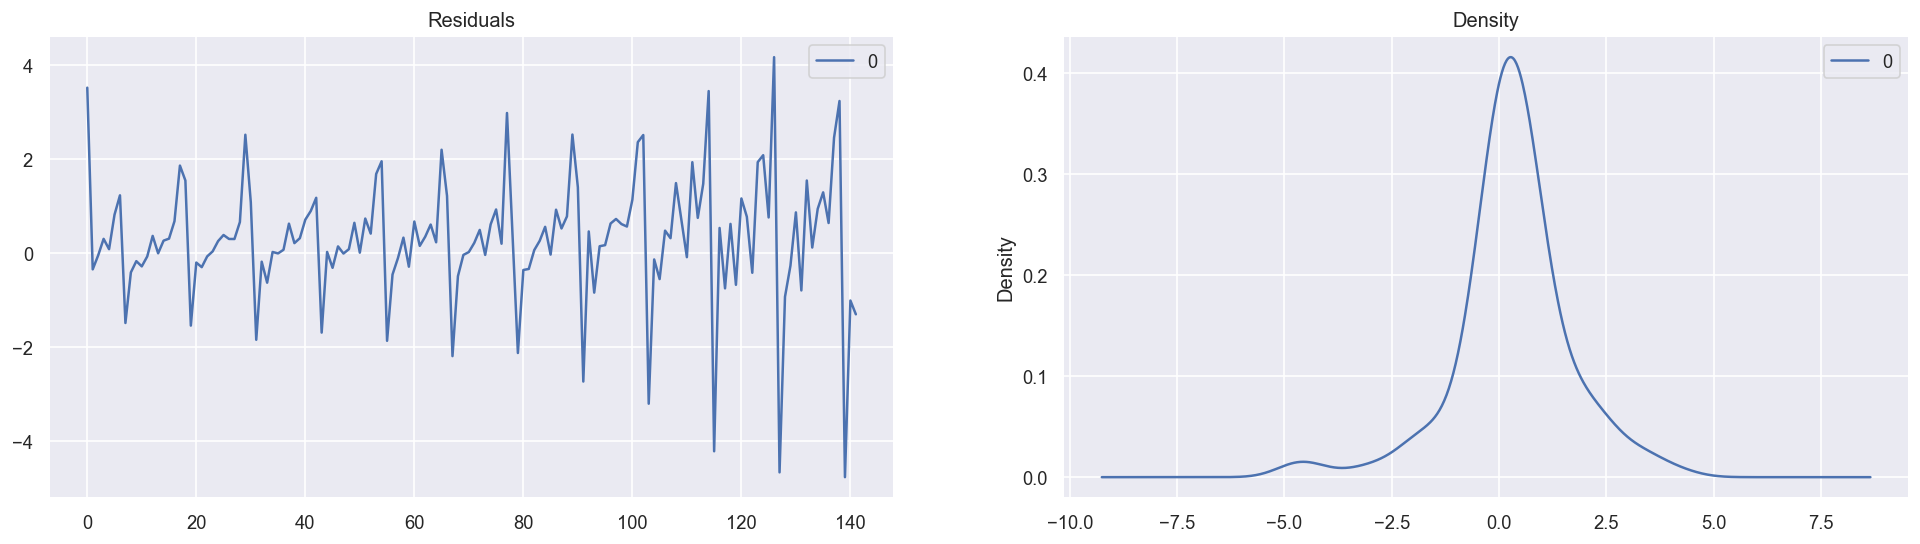

/Users/scohen6/projects/.venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


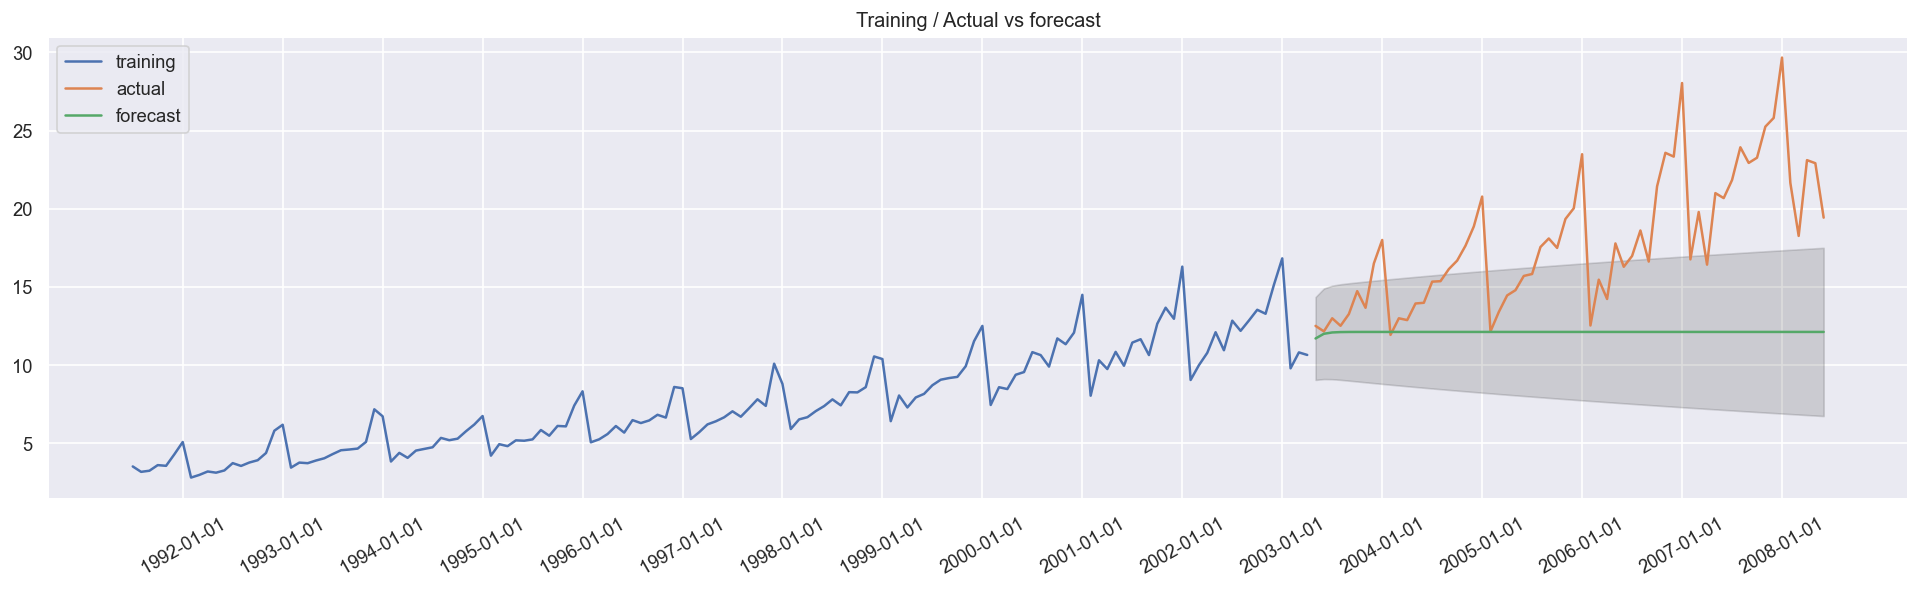

In [576]:
hyperparams = [{
    "order": (3, 2, 1),
     "train_rate": 0.7
},{
    "order": (1, 1, 2),
     "train_rate": 0.7
},{
    "order": (1, 1, 1),
     "train_rate": 0.7
}]

print("ACF / PACF of original data")
plot_acf(sample_dataset.value, "Original Dataset")
print("==================================================================================================")
date_label = sample_dataset['date'].loc[sample_dataset['date'].str.endswith('01-01')]

print(date_label)
for idx, param in enumerate(hyperparams):
    predicted_dataset = run_arima(sample_dataset, param, date_label)
    print("==================================================================================================")
    predicted_dataset = run_arima_train_test(sample_dataset, param, date_label)
    print("==================================================================================================")

# AMZN Dataset

In [577]:
path = './AMZN_data_1999_2022.csv'

amzn_dataset_original = pd.read_csv(path)

amzn_dataset_original.head()

Date      Open      High       Low     Close  Adj Close      Volume
0  1999-01-04  2.730729  2.966667  2.665625  2.957813   2.957813   785844000
1  1999-01-05  2.739063  3.243750  2.662500  3.112500   3.112500  1257464000
2  1999-01-06  3.409375  3.509375  3.350000  3.450000   3.450000   723532000
3  1999-01-07  3.428125  4.006250  3.325000  3.971875   3.971875   945492000
4  1999-01-08  4.606250  4.978125  3.800000  4.006250   4.006250  1333244000

In [578]:
ticker = yf.Ticker('AMZN')

amzn_dataset_original = ticker.history(period="max").reset_index() 
amzn_dataset_original['Date'] = amzn_dataset_original['Date'].astype(str)
amzn_dataset_original['Date'] = amzn_dataset_original['Date'].str.split().str[0]

amzn_dataset_original.head()

Date      Open      High       Low     Close      Volume  Dividends  \
0  1997-05-15  0.121875  0.125000  0.096354  0.097917  1443120000        0.0   
1  1997-05-16  0.098438  0.098958  0.085417  0.086458   294000000        0.0   
2  1997-05-19  0.088021  0.088542  0.081250  0.085417   122136000        0.0   
3  1997-05-20  0.086458  0.087500  0.081771  0.081771   109344000        0.0   
4  1997-05-21  0.081771  0.082292  0.068750  0.071354   377064000        0.0   

   Stock Splits  
0           0.0  
1           0.0  
2           0.0  
3           0.0  
4           0.0

In [579]:
mean_list = np.mean( np.array([ amzn_dataset_original['Low'], amzn_dataset_original['High'] ]), axis=0 )
datasets = {
    #'open': pd.DataFrame({'date':amzn_dataset_original['Date'], 'value':amzn_dataset_original['Open']}),
    #'close': pd.DataFrame({'date':amzn_dataset_original['Date'], 'value':amzn_dataset_original['Close']}),
    #'high': pd.DataFrame({'date':amzn_dataset_original['Date'], 'value':amzn_dataset_original['High']}),
    #'low': pd.DataFrame({'date':amzn_dataset_original['Date'], 'value':amzn_dataset_original['Low']}),
    'mean': pd.DataFrame({'date':amzn_dataset_original['Date'], 'value':mean_list}),
    'volume': pd.DataFrame({'date':amzn_dataset_original['Date'], 'value':amzn_dataset_original['Volume']})
}

In [580]:
def get_date_labels_amzn(dataset):
    date_filter = dataset.loc[dataset['date'].str.endswith('01-02') ^ dataset['date'].str.endswith('01-03') ^ dataset['date'].str.endswith('01-04')]
    date_filter['year'] = date_filter['date'].str.split('-').str[0]
    date_filter.loc[0] = dataset.iloc[0]
    date_filter.at[0, 'year'] = 'first'
    date_filter.loc[len(dataset)-1] = dataset.iloc[-1]
    date_filter.at[len(dataset)-1, 'year'] = 'last'
    date_filter = date_filter.drop_duplicates(subset=['year'], keep='first')
    date_filter = date_filter.loc[:, 'date']
    date_filter = date_filter.sort_index()
    
    return date_filter

/var/folders/04/b5_9lzx5797dzscx6rwj46k80000gr/T/ipykernel_83083/2499829597.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_filter['year'] = date_filter['date'].str.split('-').str[0]
/var/folders/04/b5_9lzx5797dzscx6rwj46k80000gr/T/ipykernel_83083/2499829597.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_filter.loc[0] = dataset.iloc[0]
/var/folders/04/b5_9lzx5797dzscx6rwj46k80000gr/T/ipykernel_83083/2499829597.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

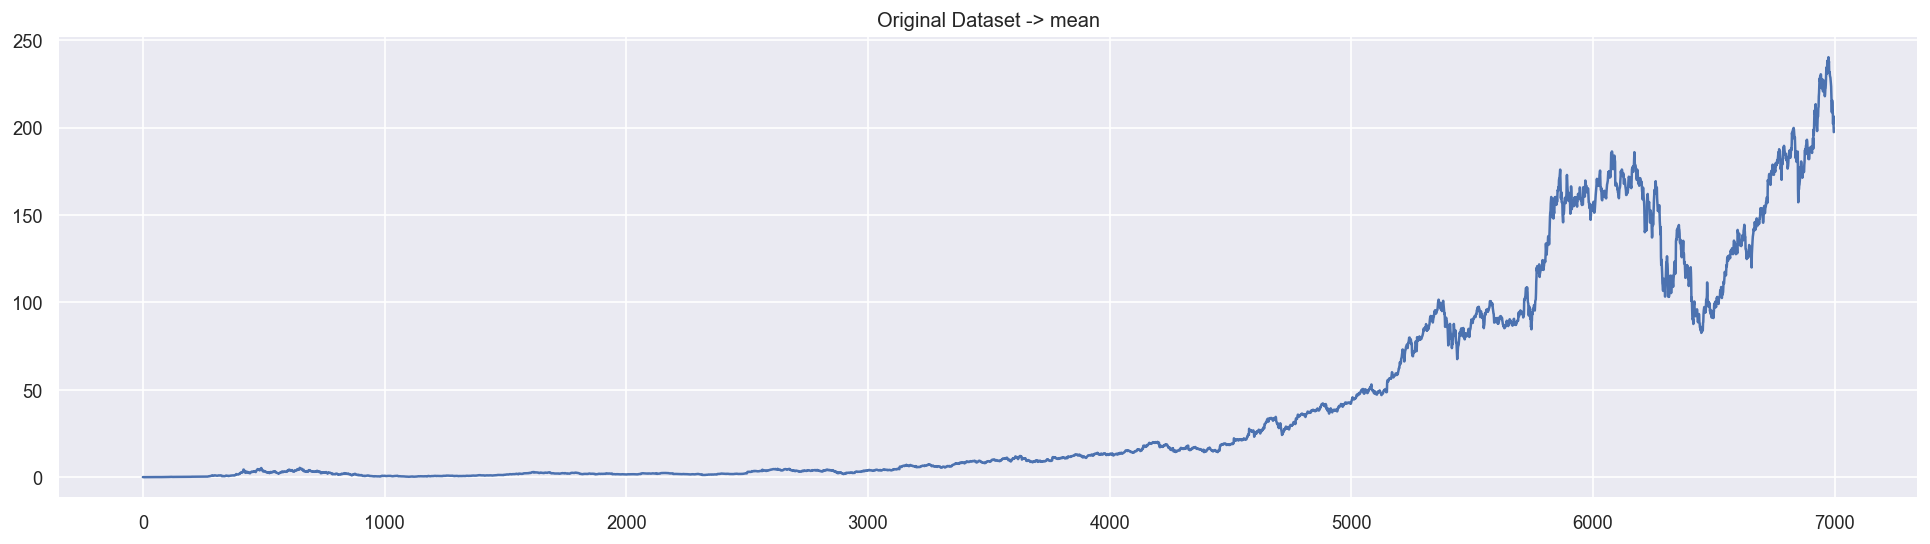

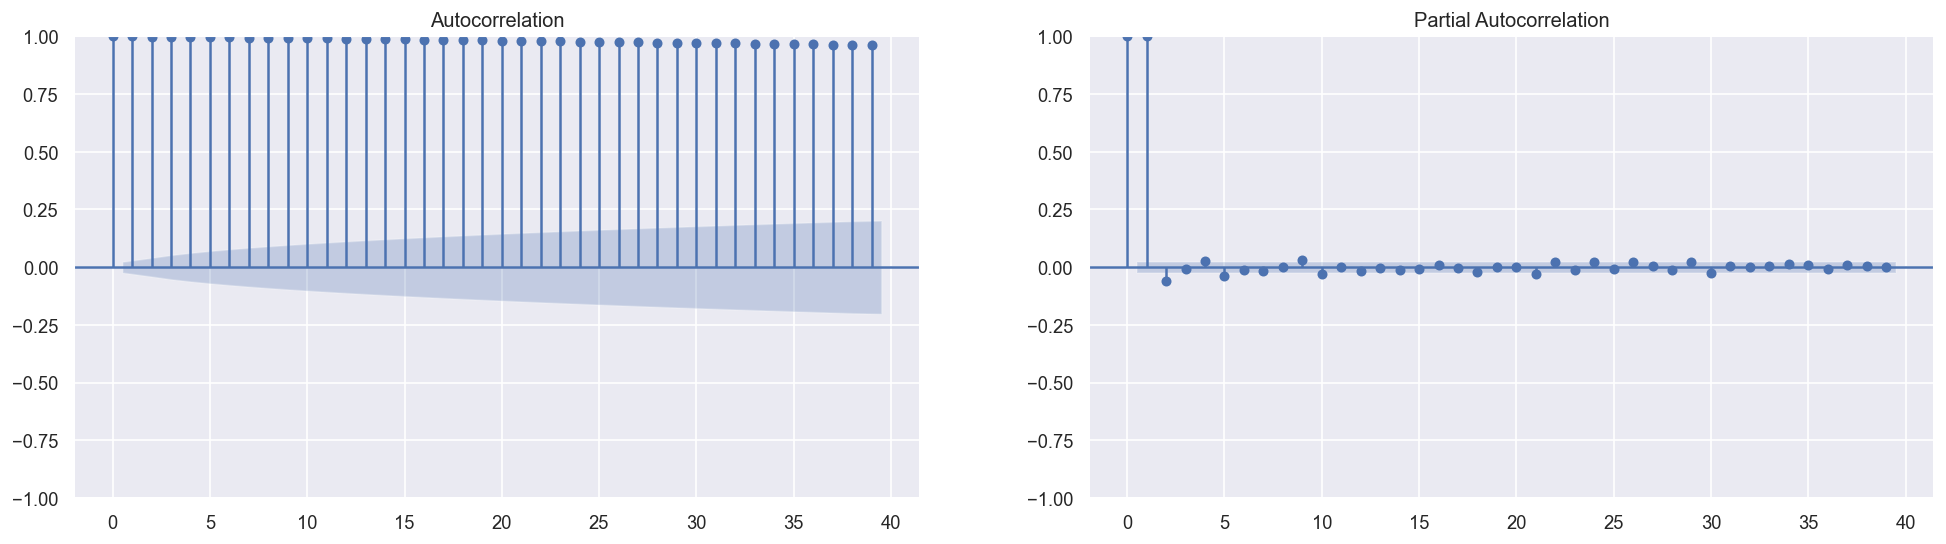

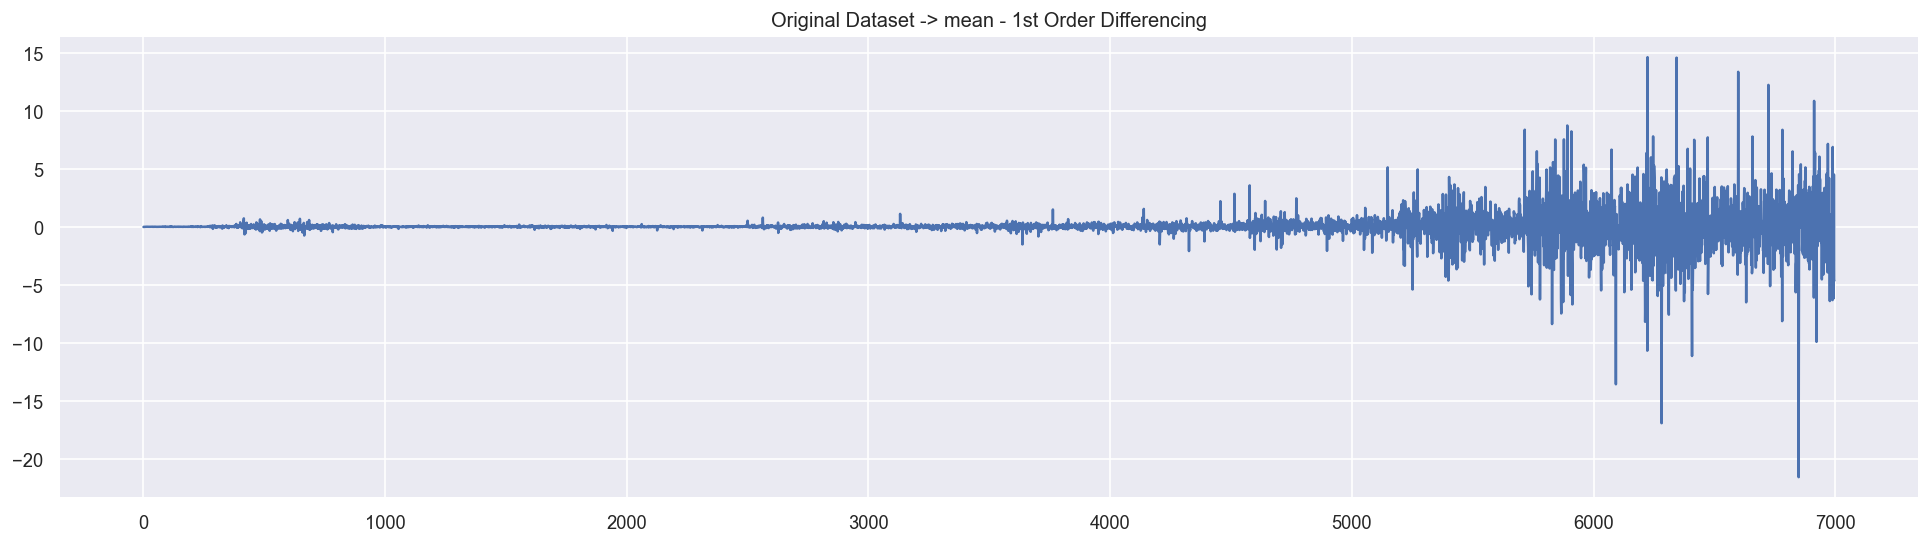

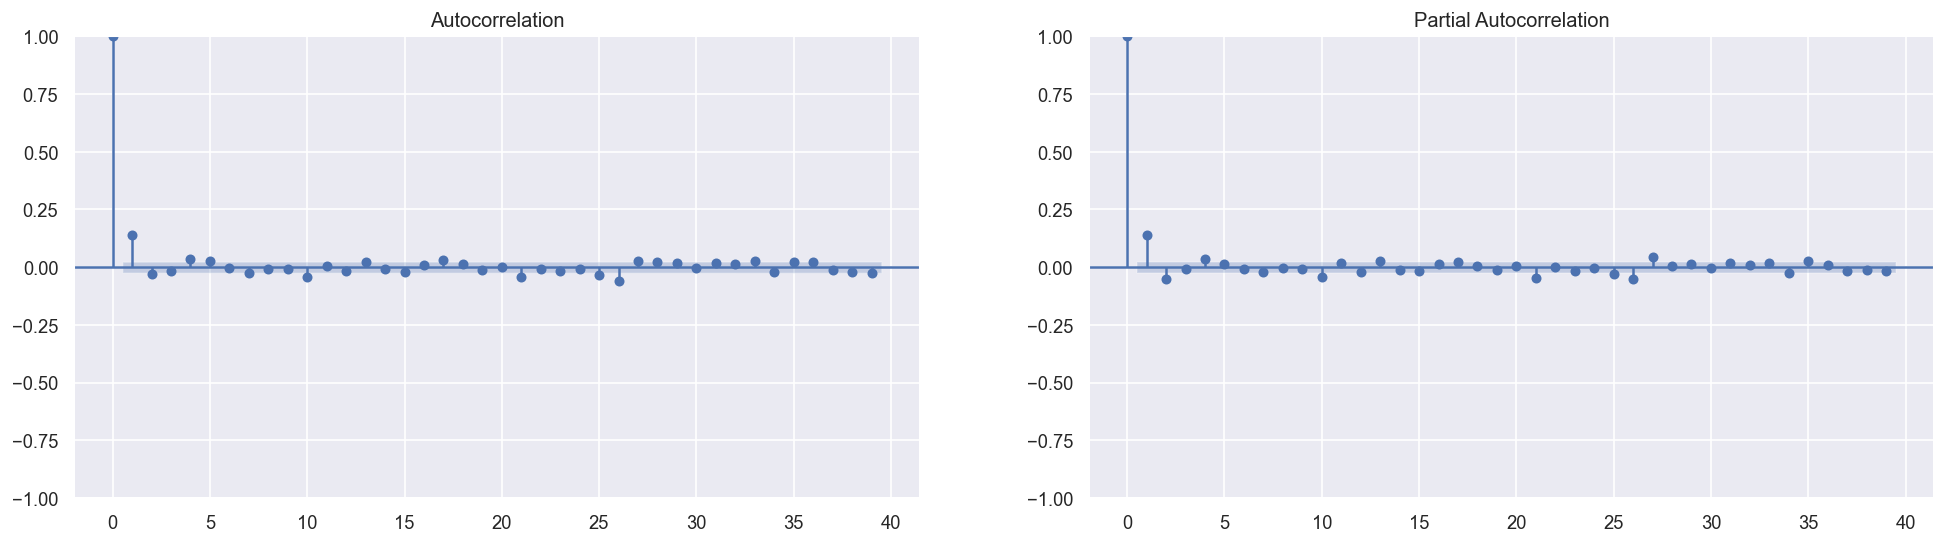

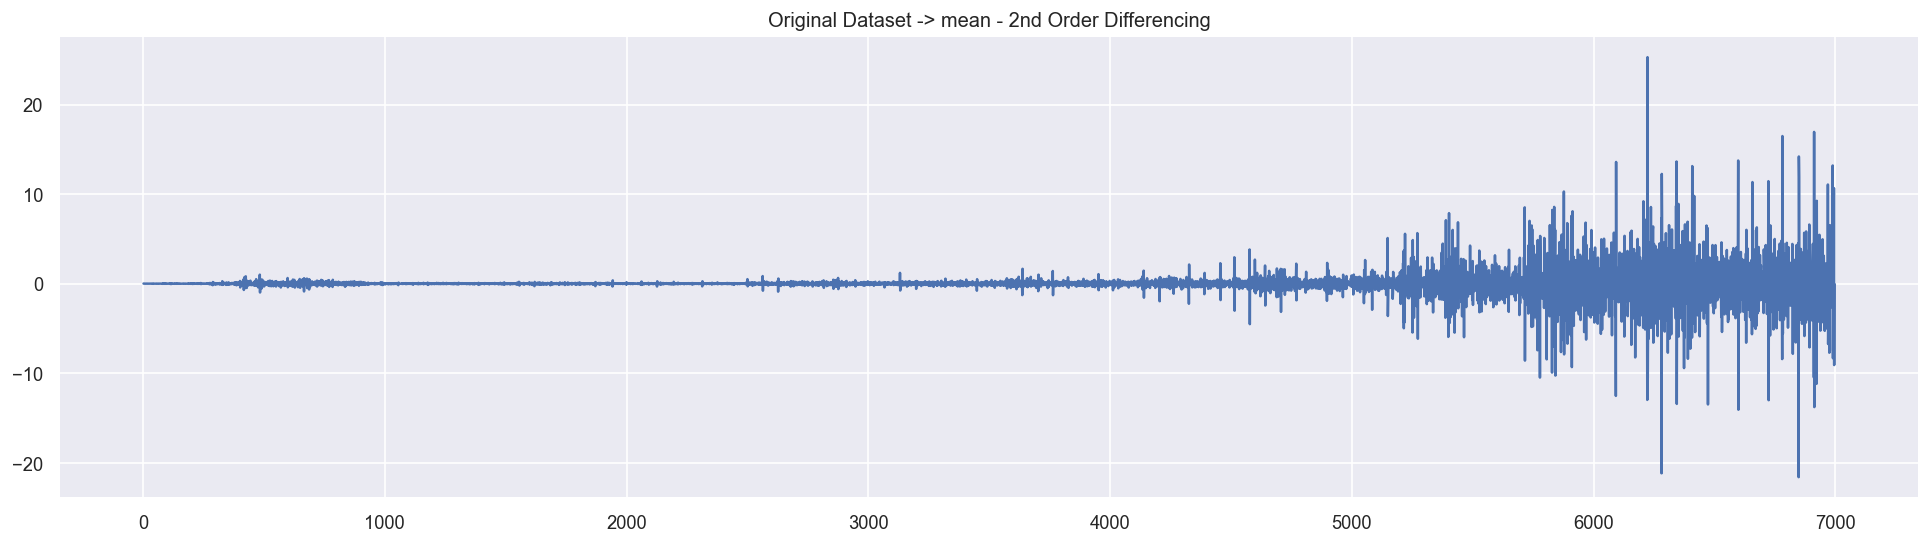

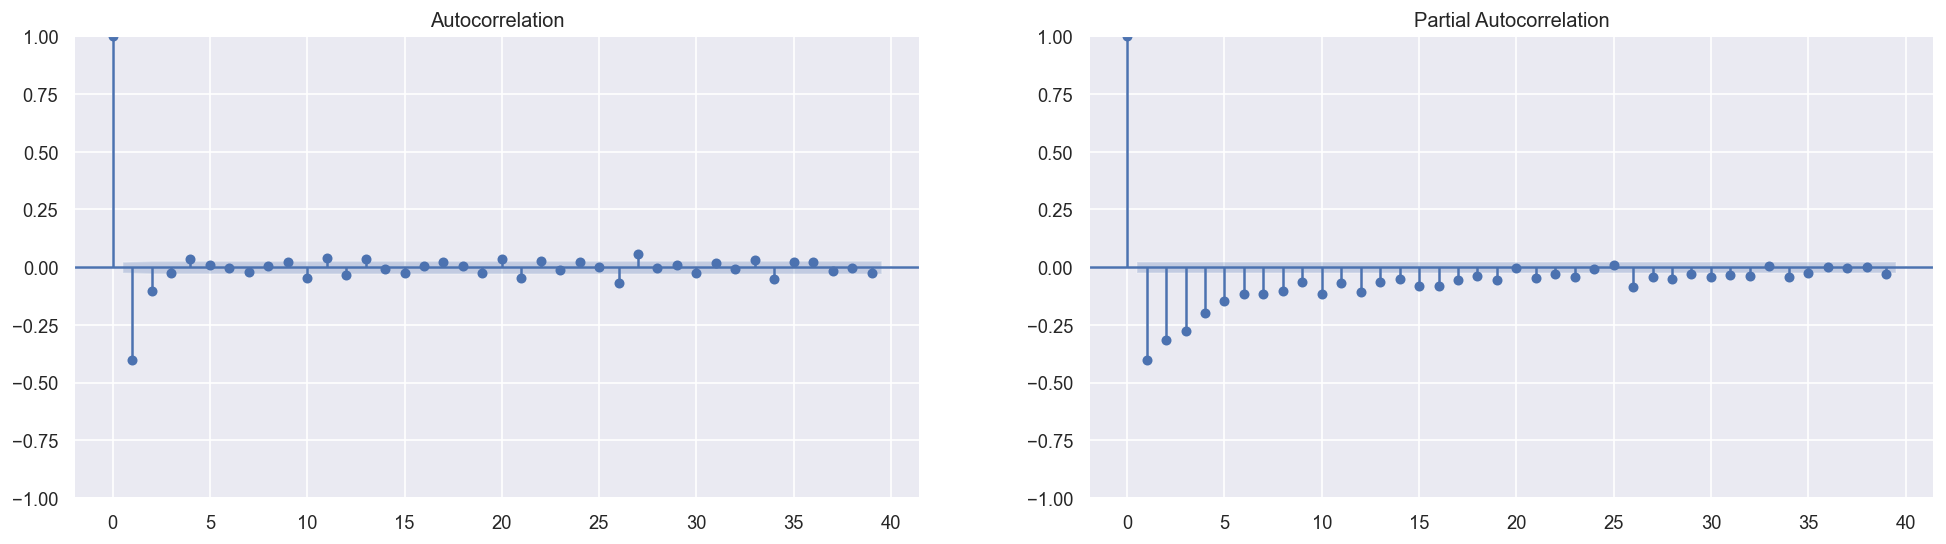

Train / Test based on:
order -> (1, 1, 2)
train_rate -> 0.7
                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                 4897
Model:                 ARIMA(1, 1, 2)   Log Likelihood                1079.107
Date:                Sun, 09 Mar 2025   AIC                          -2150.213
Time:                        00:27:19   BIC                          -2124.228
Sample:                             0   HQIC                         -2141.096
                               - 4897                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6067      0.214      2.831      0.005       0.187       1.027
ma.L1         -0.4613      0.213     -2.163      0.031      -0.879     

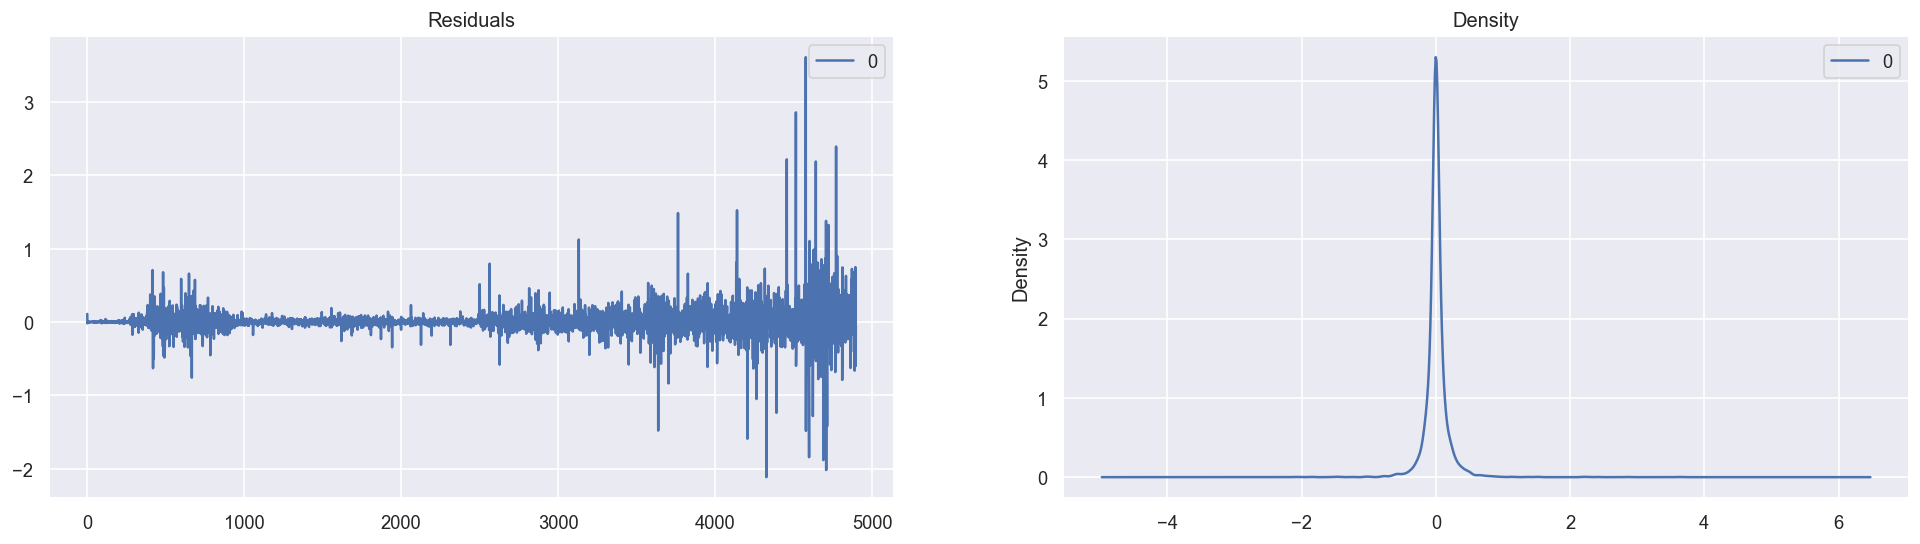

/Users/scohen6/projects/.venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


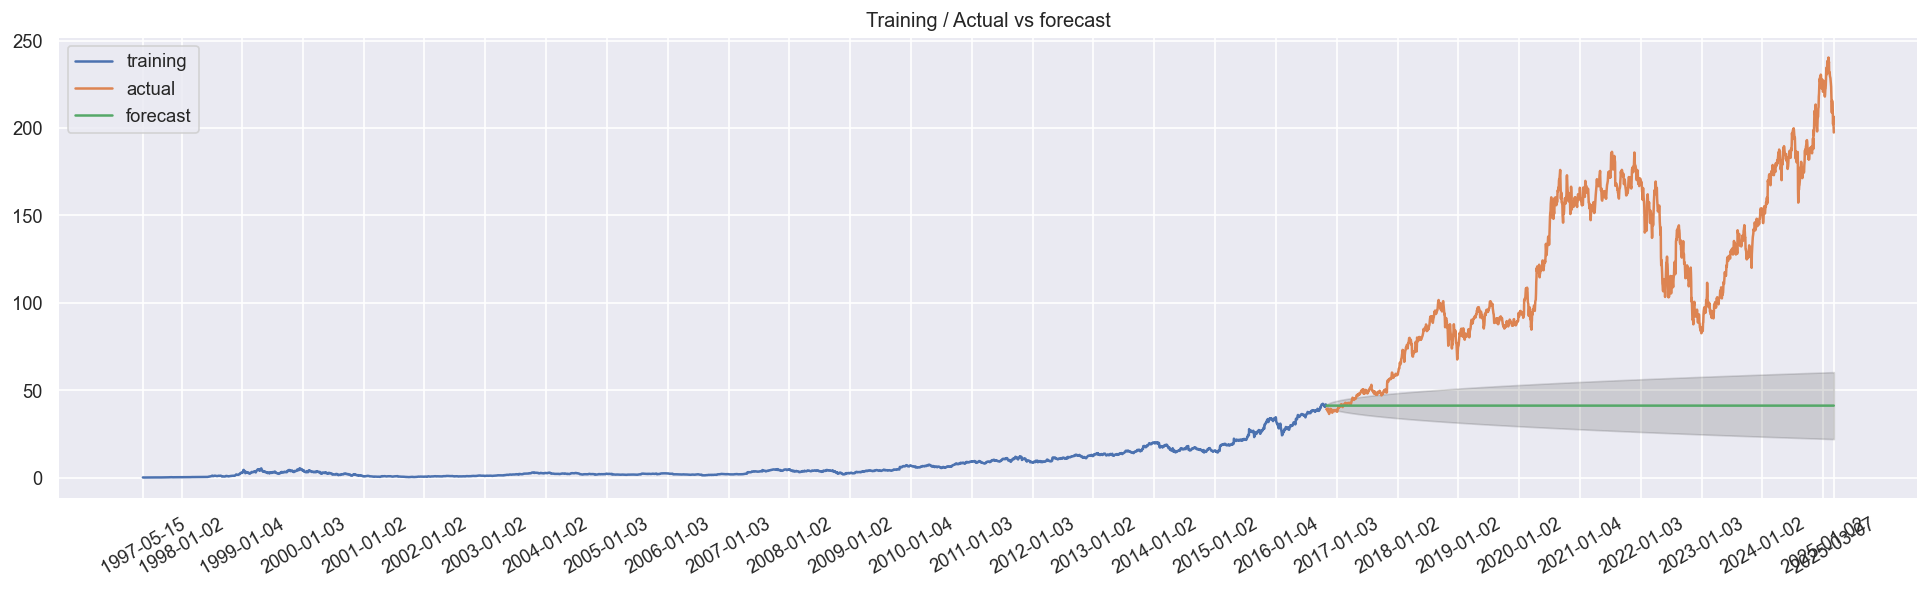

Train / Test based on:
order -> (1, 1, 1)
train_rate -> 0.7
                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                 4897
Model:                 ARIMA(1, 1, 1)   Log Likelihood                1077.989
Date:                Sun, 09 Mar 2025   AIC                          -2149.978
Time:                        00:27:20   BIC                          -2130.490
Sample:                             0   HQIC                         -2143.141
                               - 4897                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0175      0.053     -0.328      0.743      -0.122       0.087
ma.L1          0.1657      0.053      3.147      0.002       0.063     

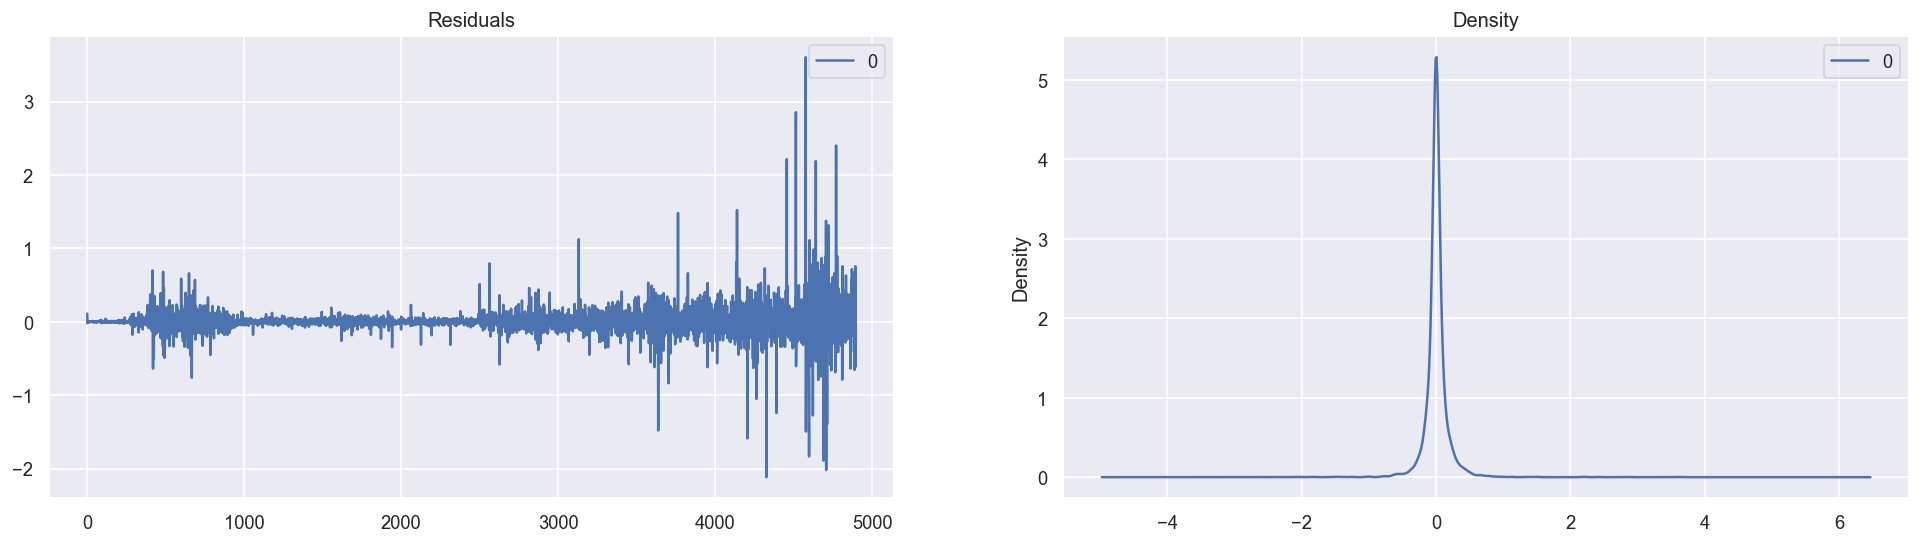

/Users/scohen6/projects/.venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


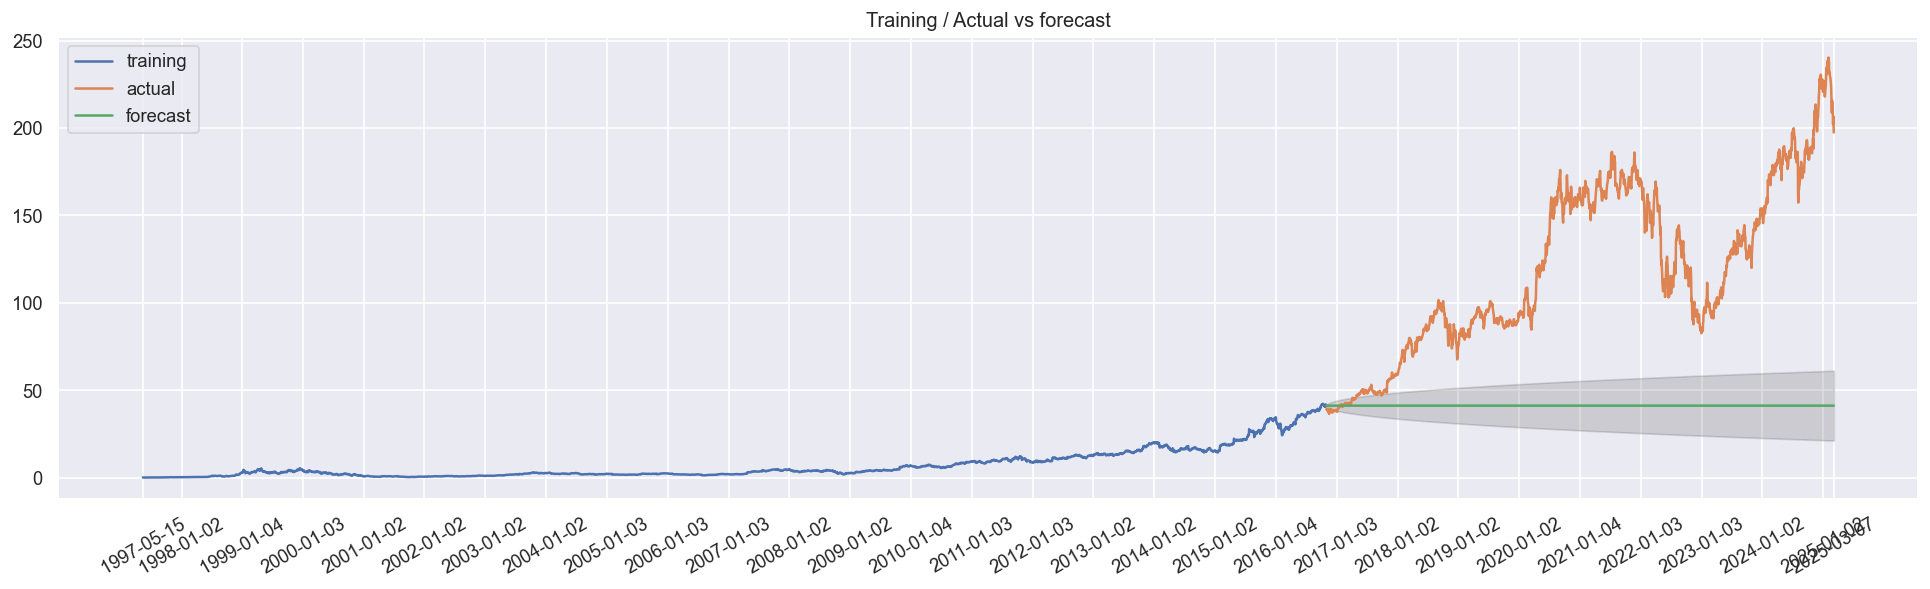

Train / Test based on:
order -> (3, 3, 3)
train_rate -> 0.7


/Users/scohen6/projects/.venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                 4897
Model:                 ARIMA(3, 3, 3)   Log Likelihood                1070.270
Date:                Sun, 09 Mar 2025   AIC                          -2126.541
Time:                        00:27:25   BIC                          -2081.071
Sample:                             0   HQIC                         -2110.587
                               - 4897                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8640      0.008   -112.433      0.000      -0.879      -0.849
ar.L2          0.1161      0.009     12.289      0.000       0.098       0.135
ar.L3         -0.0193      0.008     -2.378      0.0

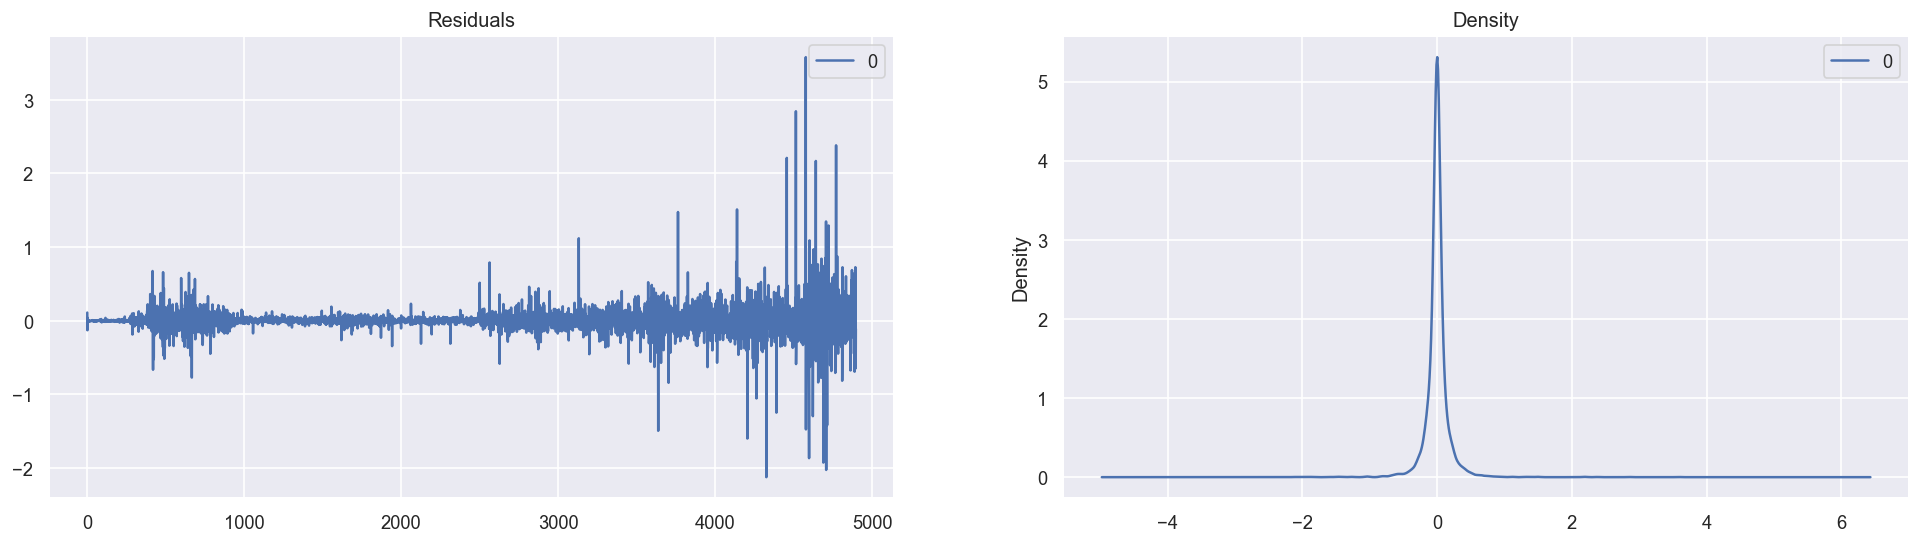

/Users/scohen6/projects/.venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


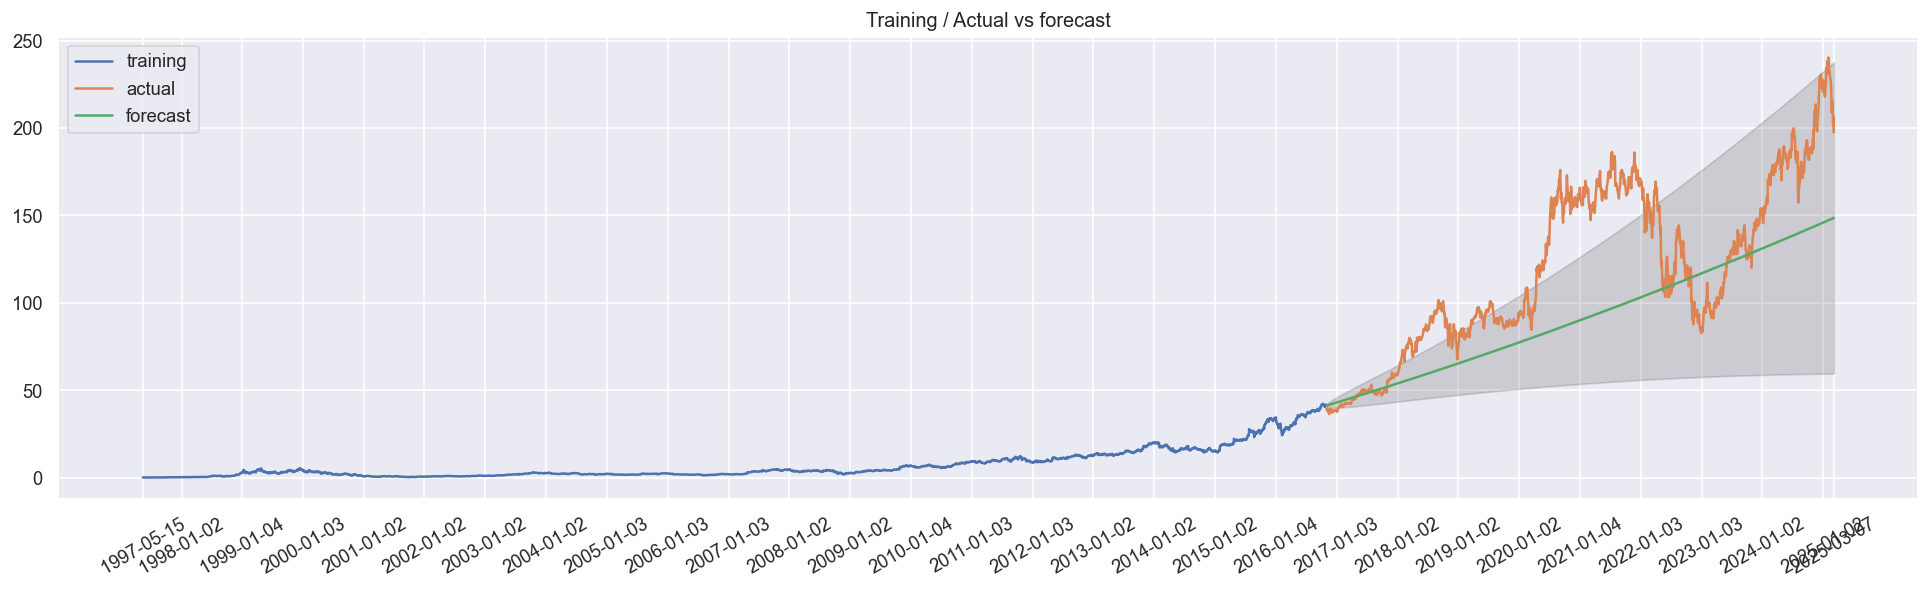

Train / Test based on:
order -> (3, 2, 1)
train_rate -> 0.7
                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                 4897
Model:                 ARIMA(3, 2, 1)   Log Likelihood                1083.735
Date:                Sun, 09 Mar 2025   AIC                          -2157.471
Time:                        00:27:27   BIC                          -2124.991
Sample:                             0   HQIC                         -2146.075
                               - 4897                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1437      0.005     29.952      0.000       0.134       0.153
ar.L2         -0.0334      0.008     -4.123      0.000      -0.049     

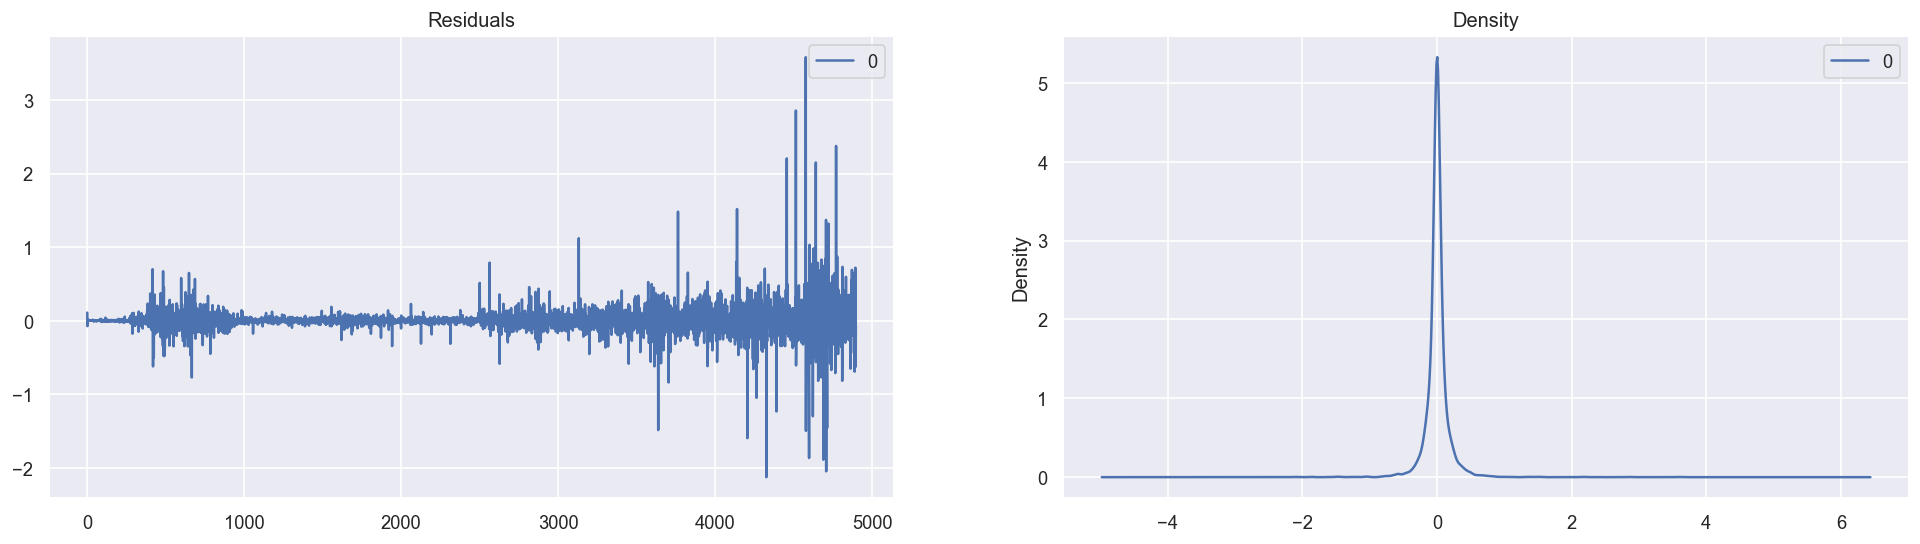

/Users/scohen6/projects/.venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


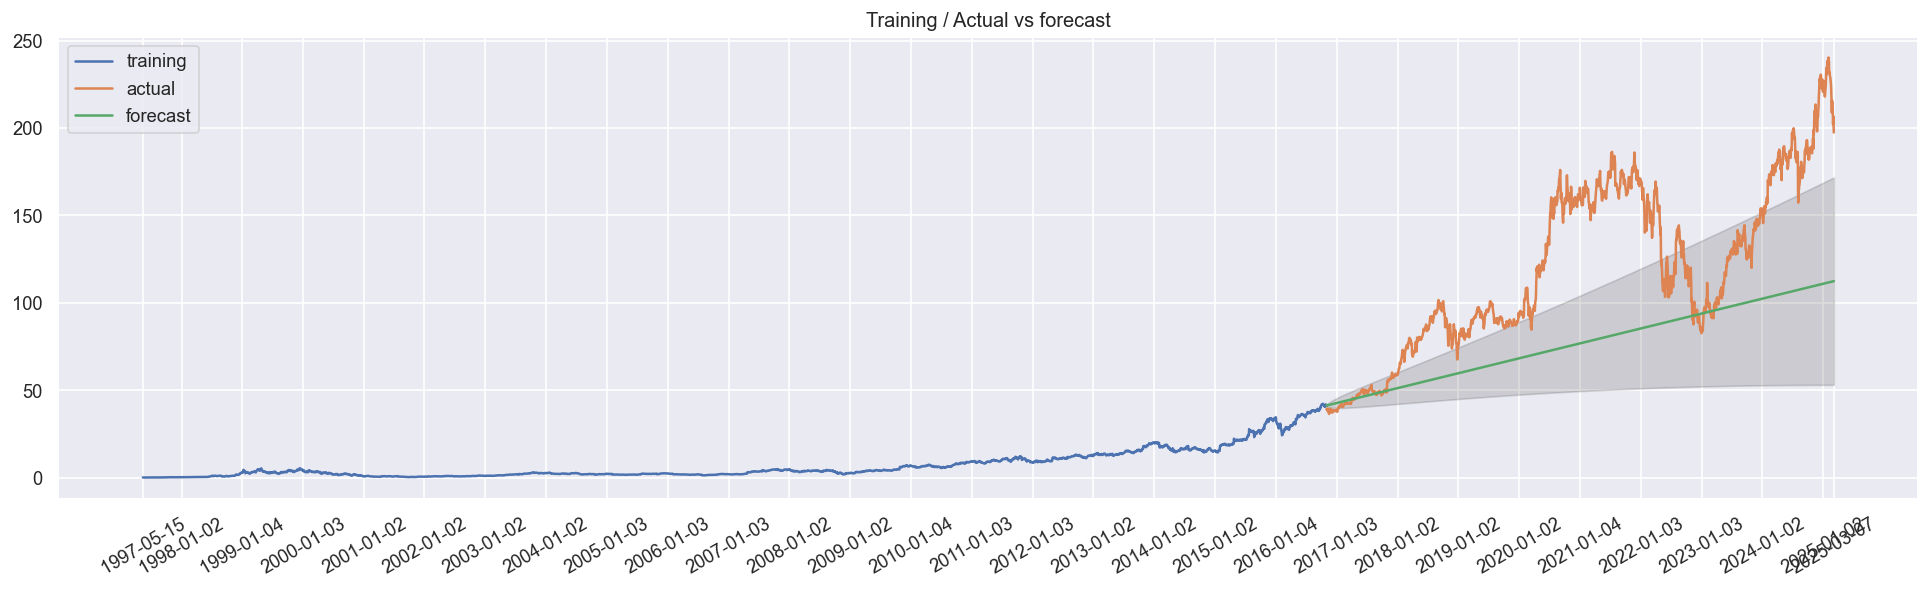

Train / Test based on:
order -> (3, 2, 1)
train_rate -> 0.8
                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                 5597
Model:                 ARIMA(3, 2, 1)   Log Likelihood               -3398.602
Date:                Sun, 09 Mar 2025   AIC                           6807.205
Time:                        00:27:28   BIC                           6840.353
Sample:                             0   HQIC                          6818.757
                               - 5597                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1740      0.004     47.508      0.000       0.167       0.181
ar.L2         -0.0573      0.004    -14.008      0.000      -0.065     

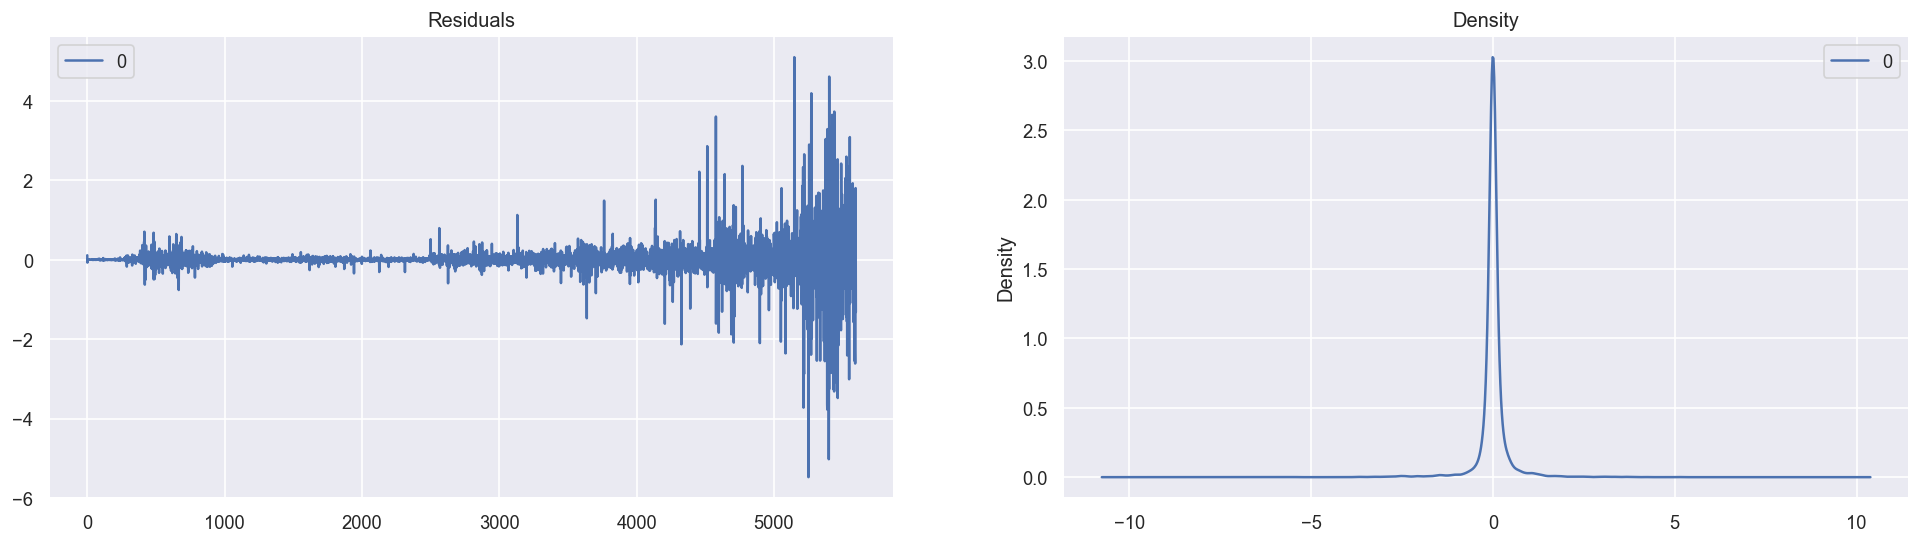

/Users/scohen6/projects/.venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


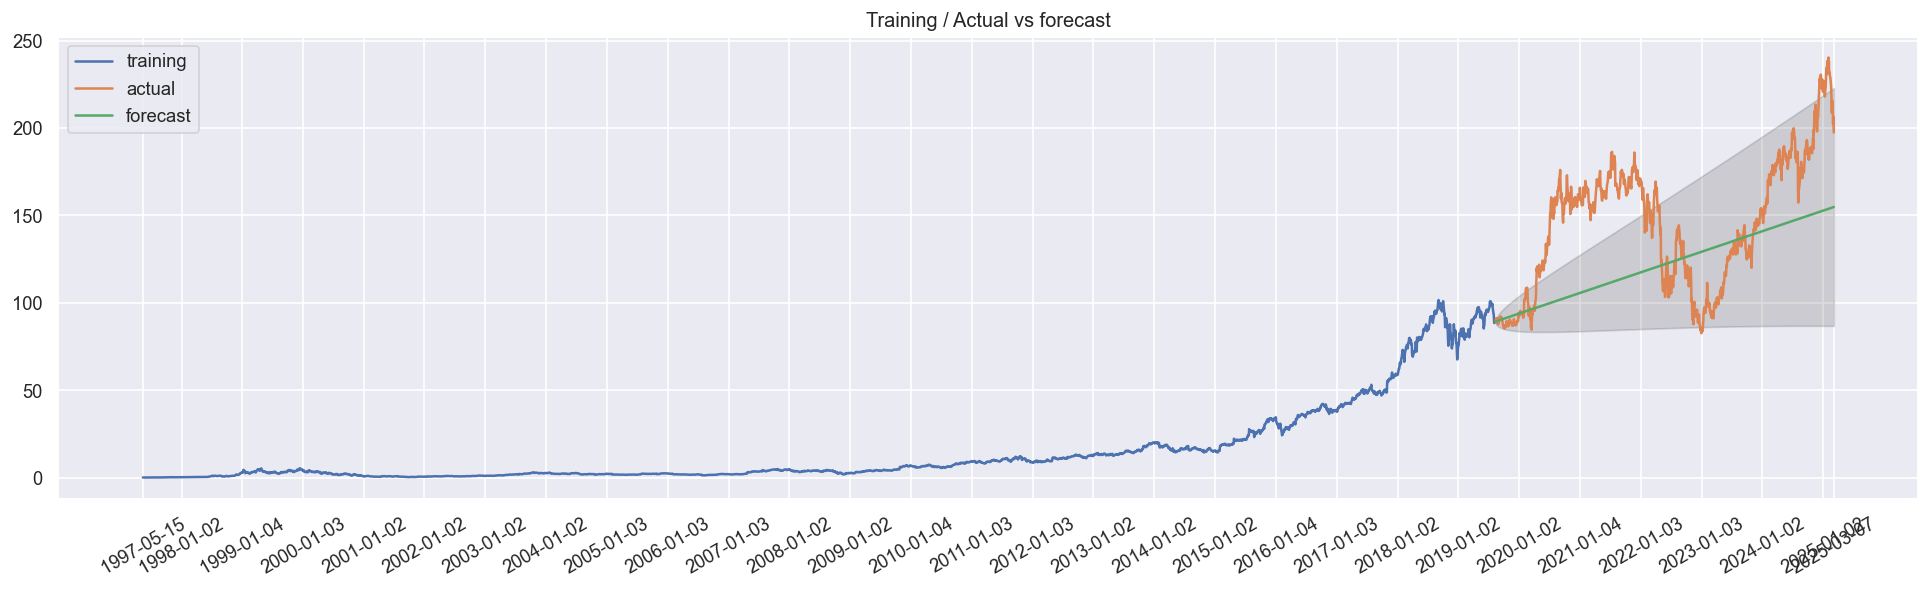

Train / Test based on:
order -> (3, 2, 1)
train_rate -> 0.9
                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                 6297
Model:                 ARIMA(3, 2, 1)   Log Likelihood               -8529.171
Date:                Sun, 09 Mar 2025   AIC                          17068.341
Time:                        00:27:30   BIC                          17102.079
Sample:                             0   HQIC                         17080.029
                               - 6297                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1941      0.004     48.690      0.000       0.186       0.202
ar.L2         -0.0790      0.005    -14.698      0.000      -0.090     

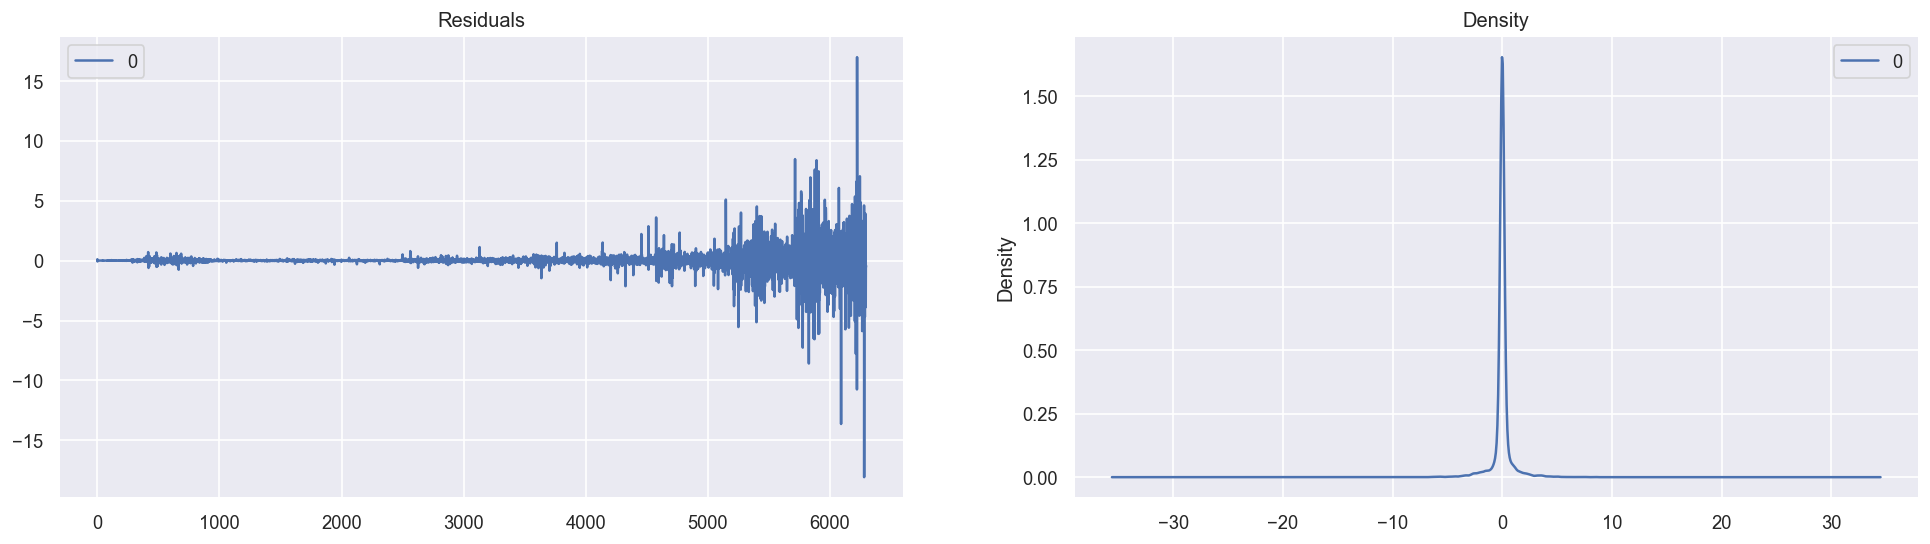

/Users/scohen6/projects/.venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


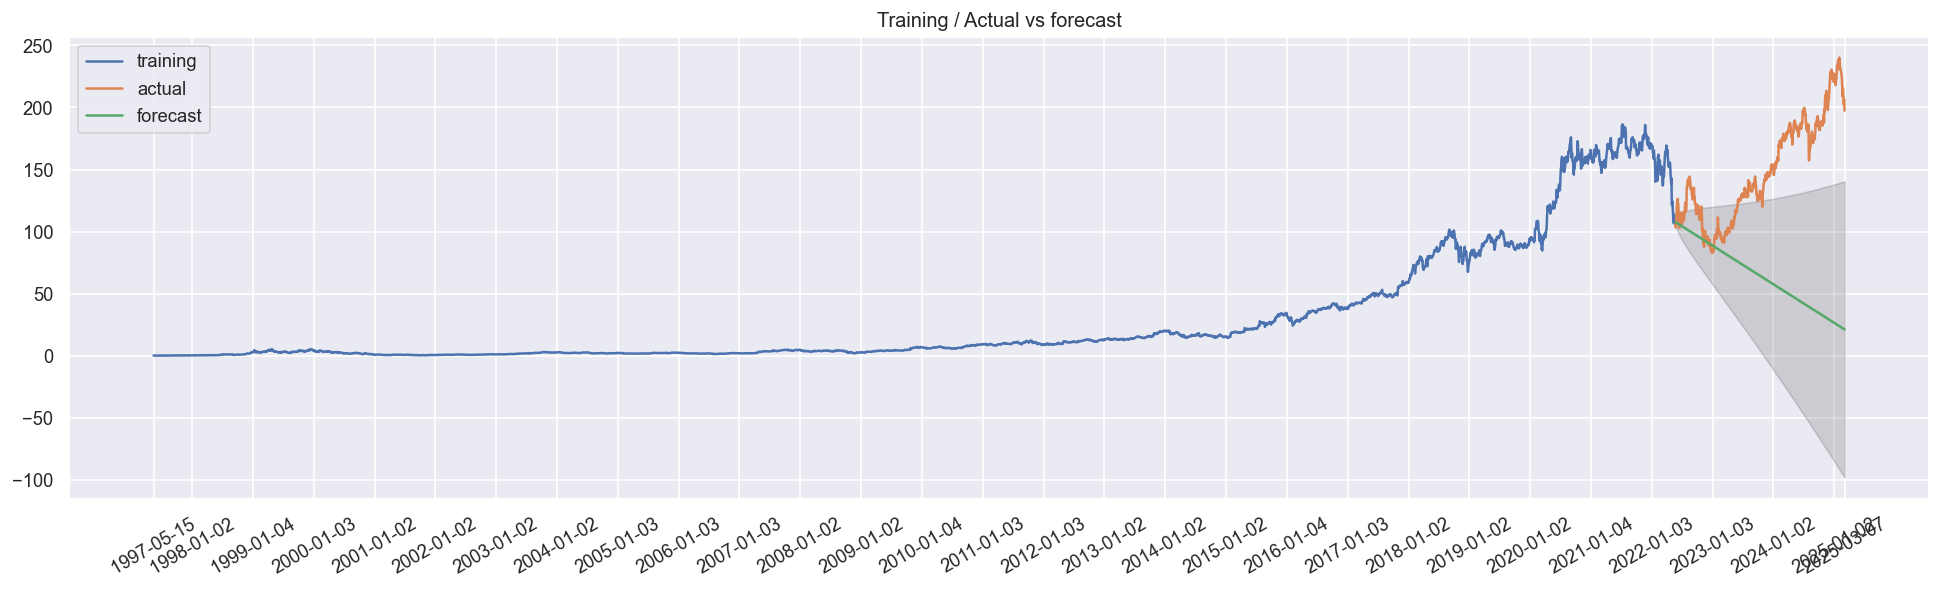

/var/folders/04/b5_9lzx5797dzscx6rwj46k80000gr/T/ipykernel_83083/2499829597.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_filter['year'] = date_filter['date'].str.split('-').str[0]
/var/folders/04/b5_9lzx5797dzscx6rwj46k80000gr/T/ipykernel_83083/2499829597.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_filter.loc[0] = dataset.iloc[0]
/var/folders/04/b5_9lzx5797dzscx6rwj46k80000gr/T/ipykernel_83083/2499829597.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

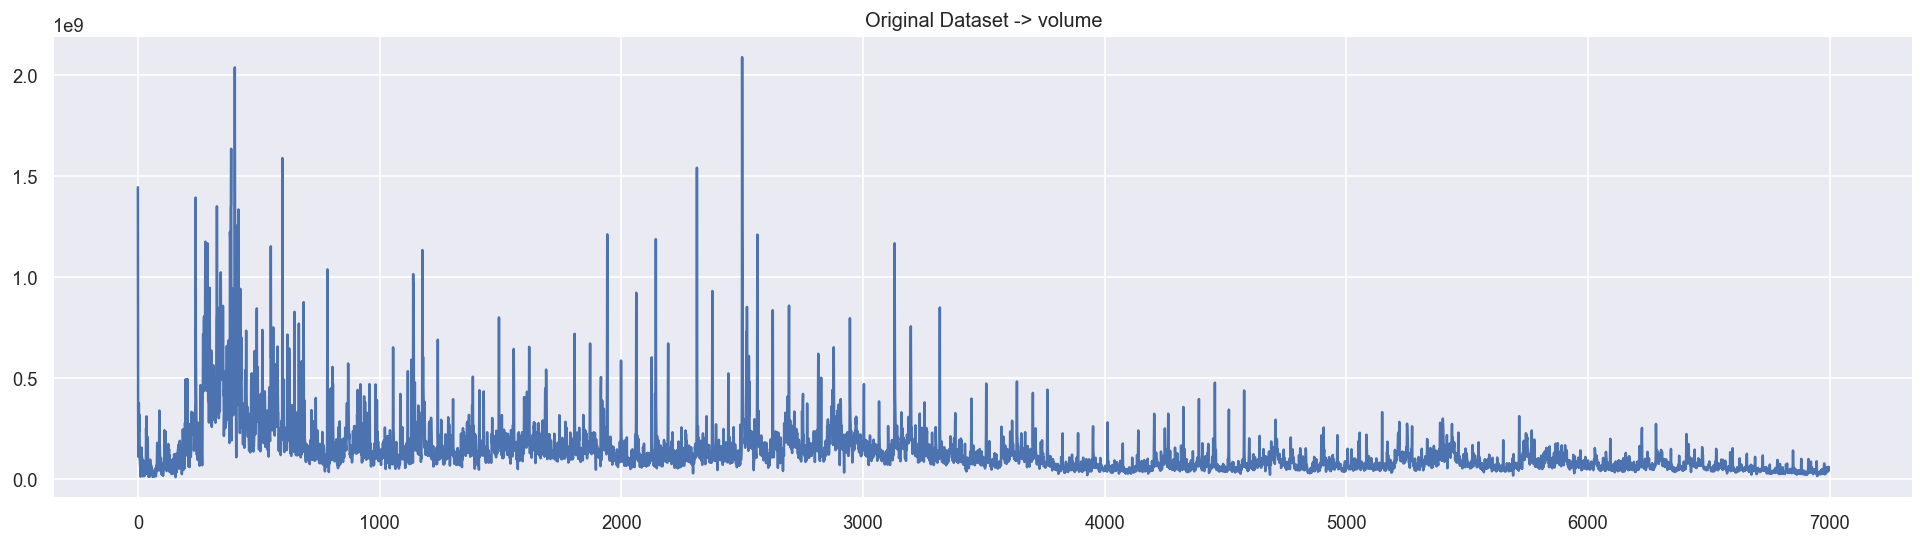

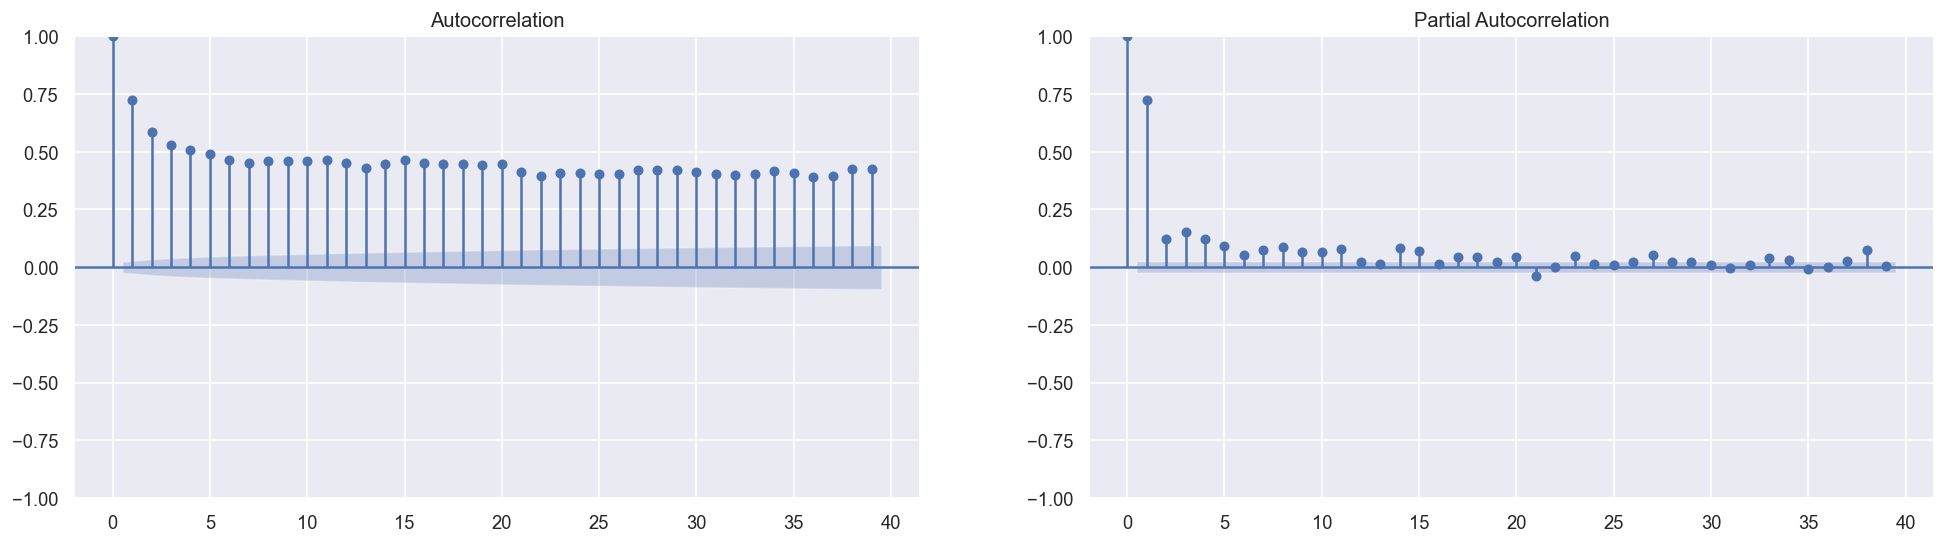

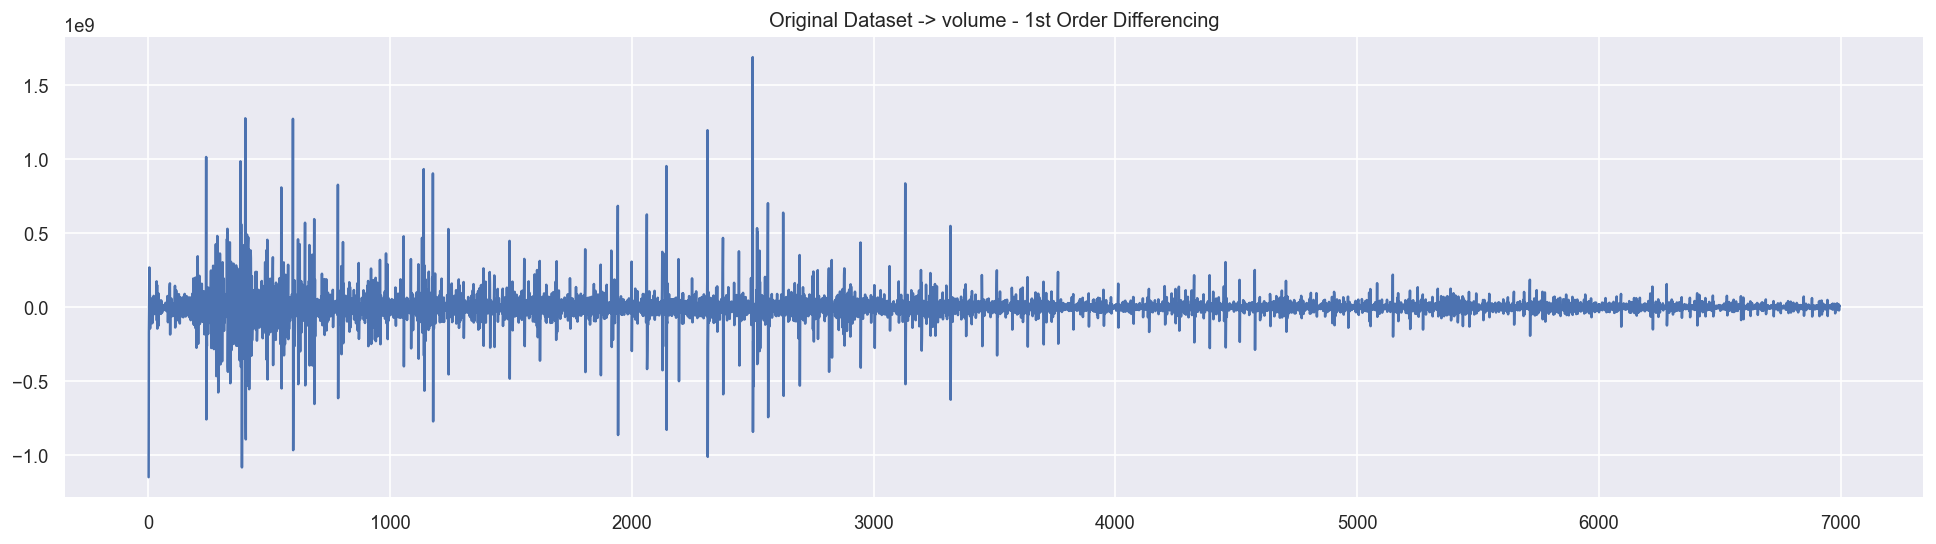

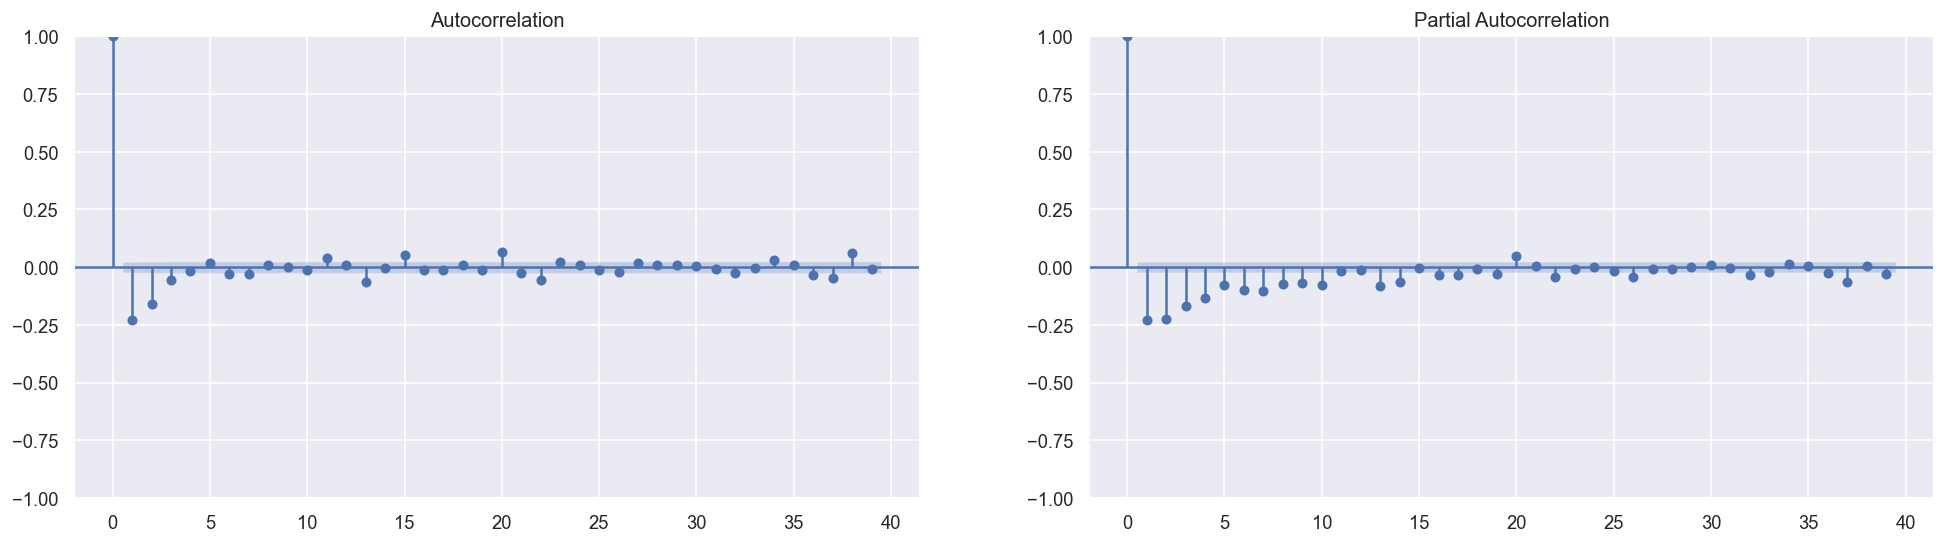

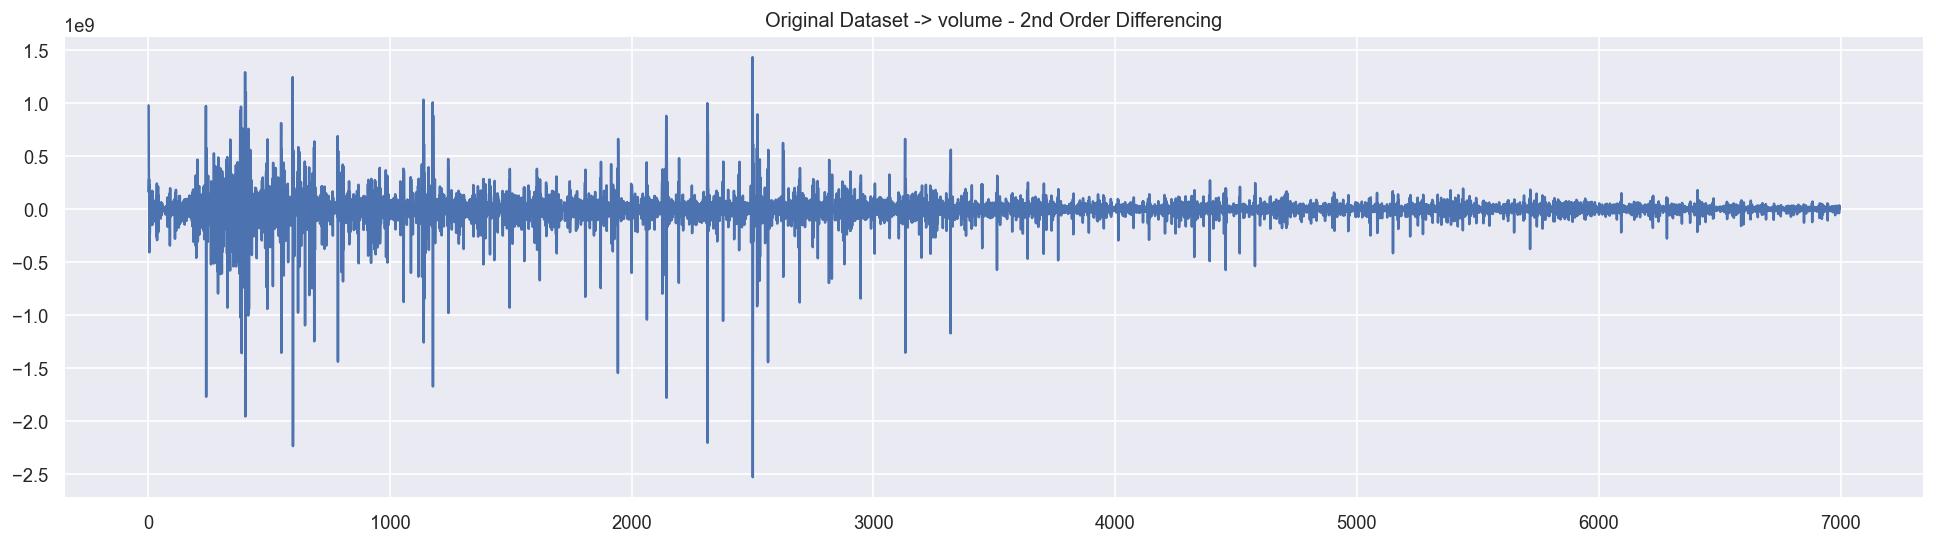

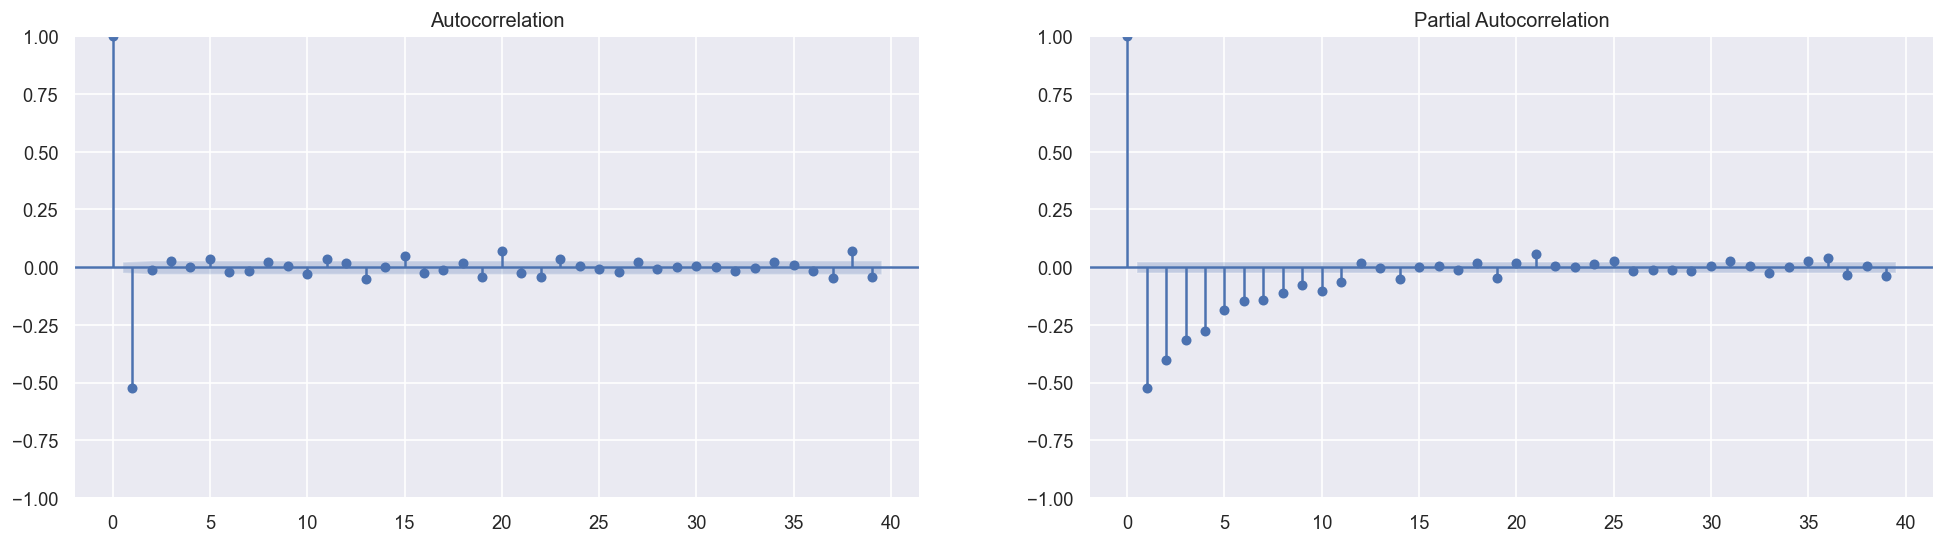

Train / Test based on:
order -> (1, 1, 2)
train_rate -> 0.7
                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                 4897
Model:                 ARIMA(1, 1, 2)   Log Likelihood              -97357.540
Date:                Sun, 09 Mar 2025   AIC                         194723.080
Time:                        00:27:33   BIC                         194749.065
Sample:                             0   HQIC                        194732.197
                               - 4897                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4633      0.016     29.365      0.000       0.432       0.494
ma.L1         -0.9243      0.017    -53.658      0.000      -0.958     

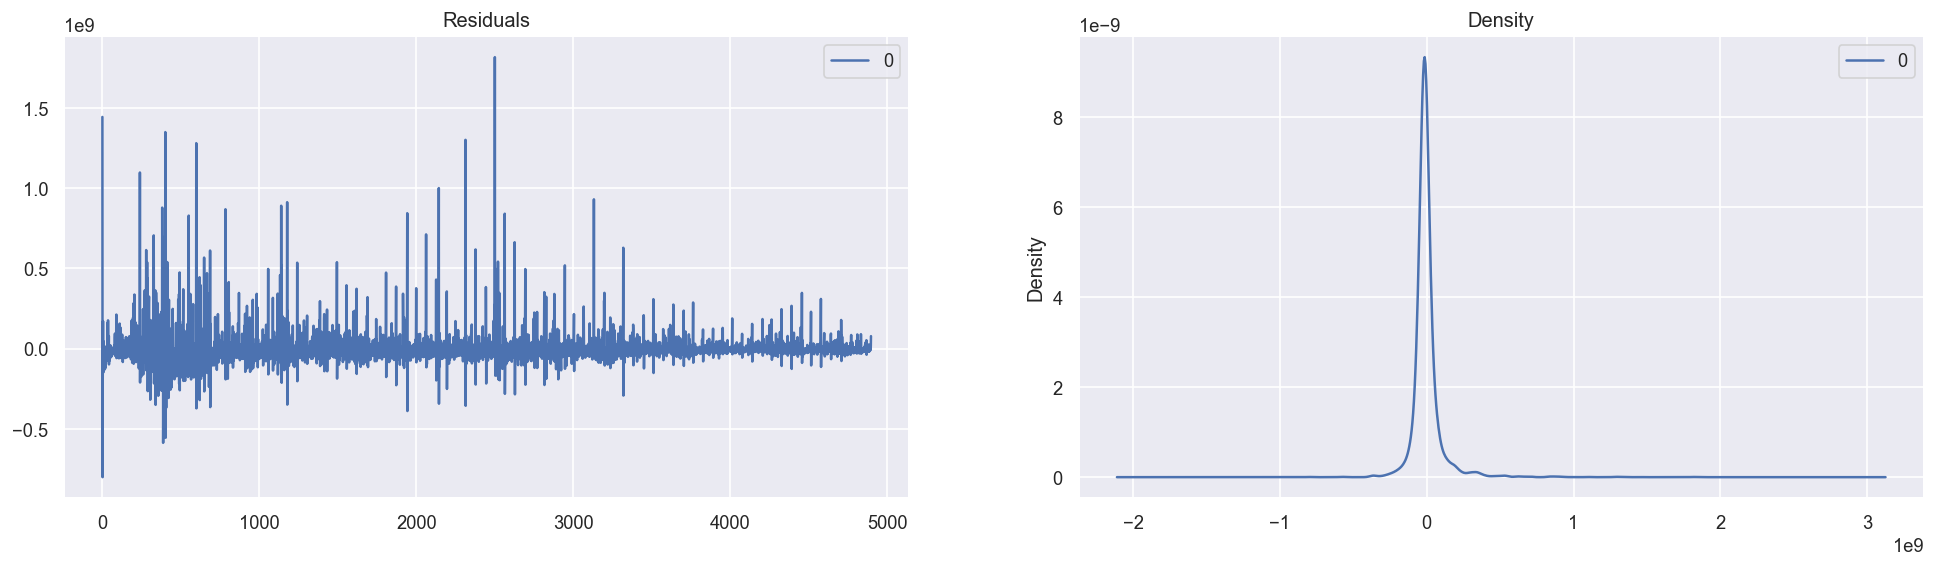

/Users/scohen6/projects/.venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


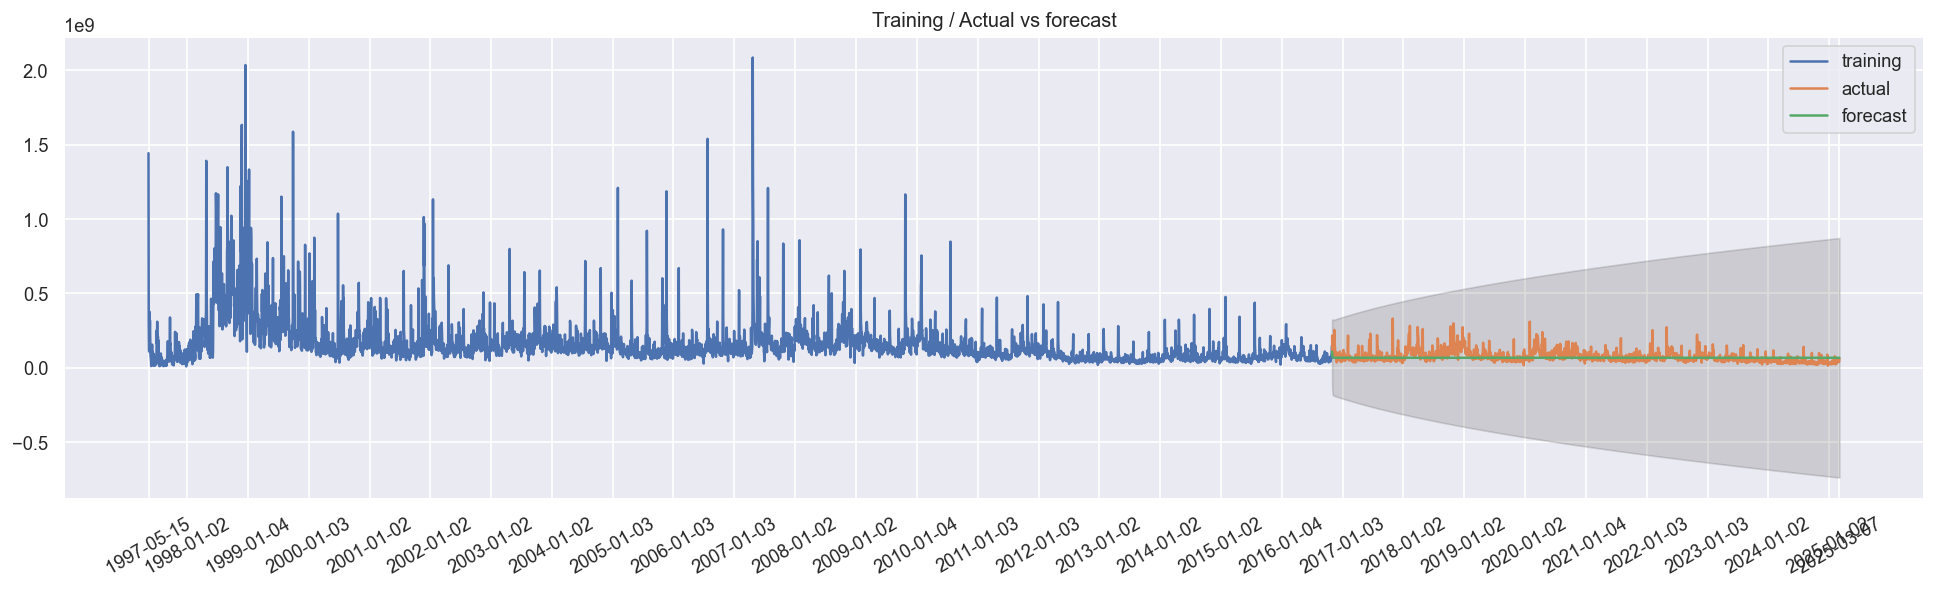

Train / Test based on:
order -> (1, 1, 1)
train_rate -> 0.7
                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                 4897
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -97364.275
Date:                Sun, 09 Mar 2025   AIC                         194734.551
Time:                        00:27:34   BIC                         194754.039
Sample:                             0   HQIC                        194741.388
                               - 4897                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4923      0.007     70.537      0.000       0.479       0.506
ma.L1         -0.9608      0.003   -319.147      0.000      -0.967     

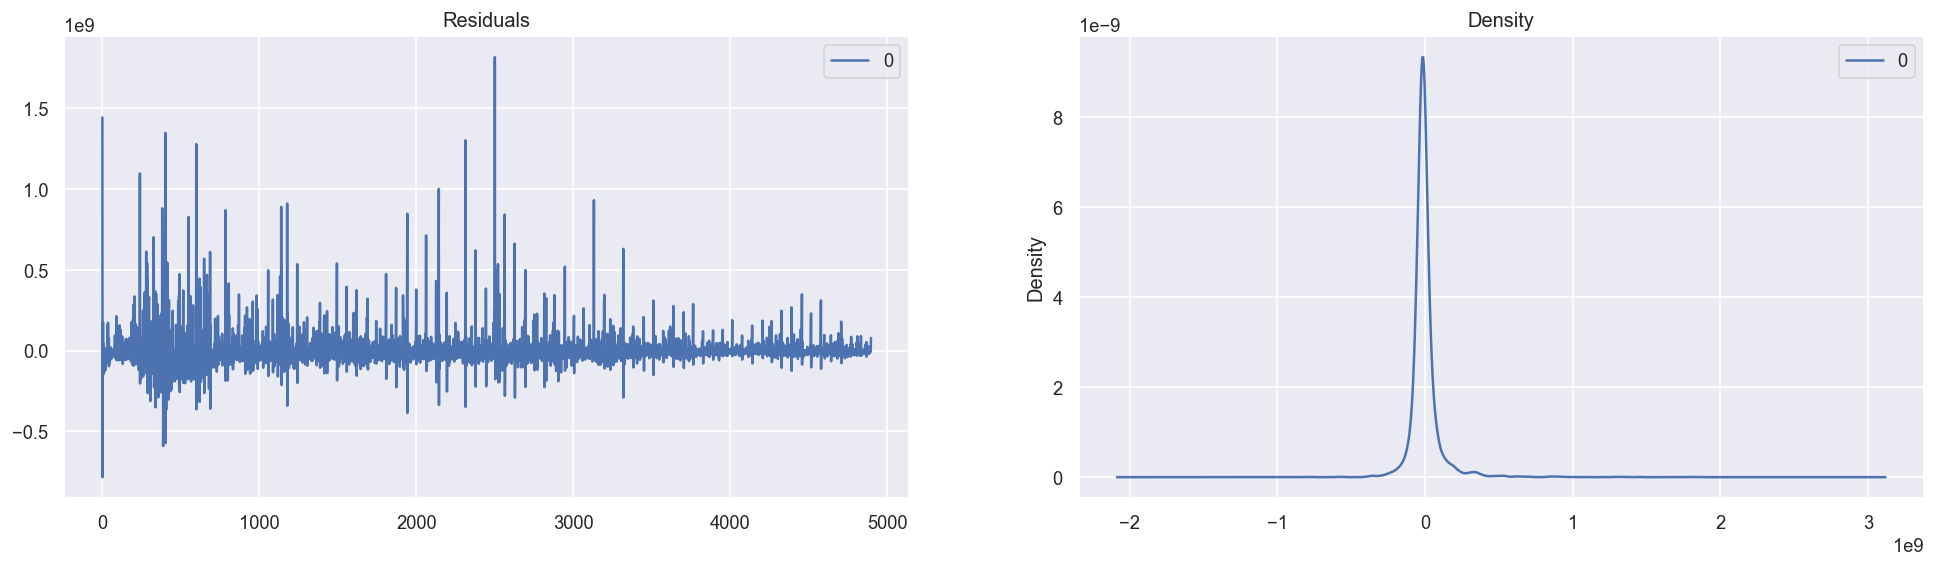

/Users/scohen6/projects/.venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


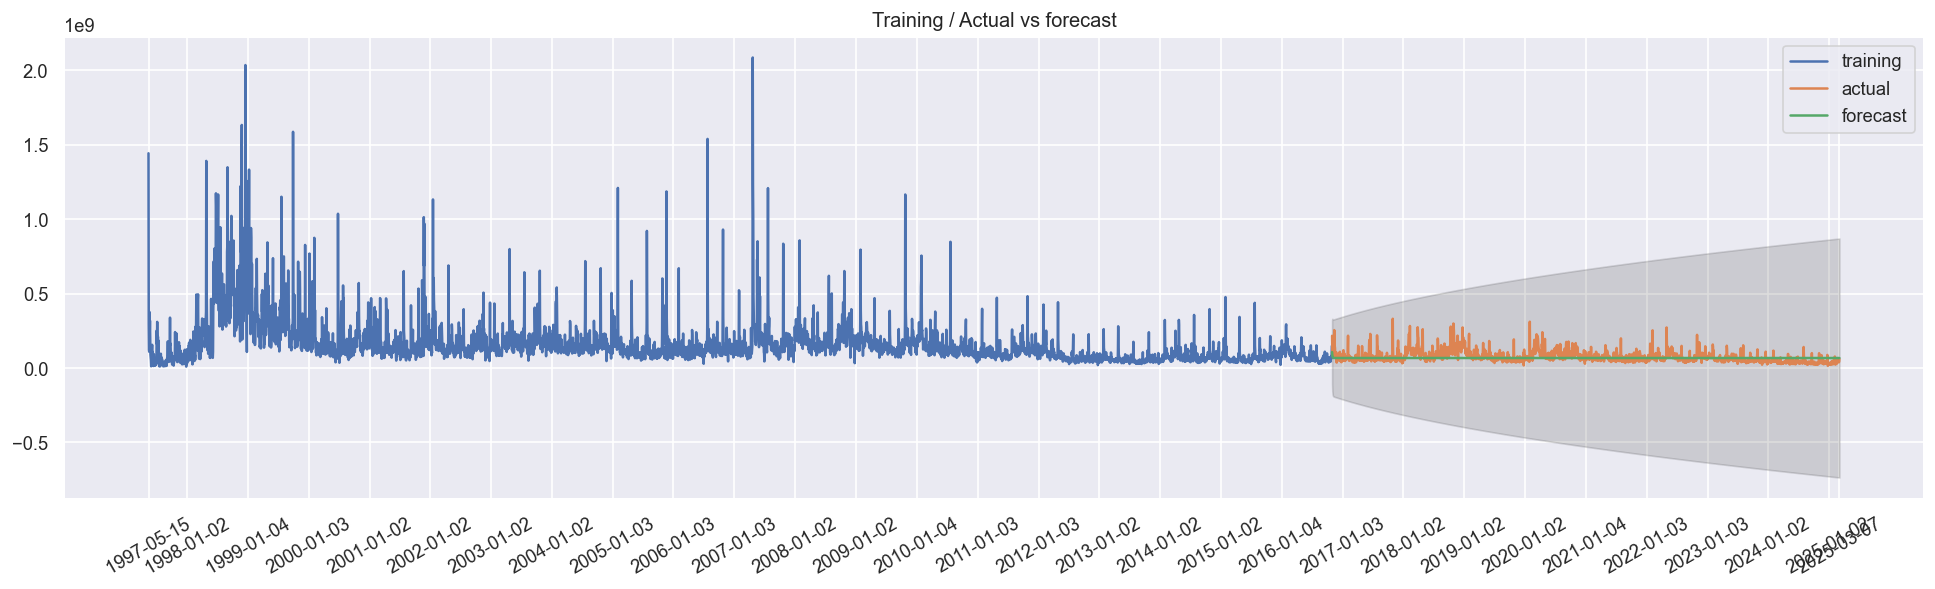

Train / Test based on:
order -> (3, 3, 3)
train_rate -> 0.7


/Users/scohen6/projects/.venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                 4897
Model:                 ARIMA(3, 3, 3)   Log Likelihood              -97950.397
Date:                Sun, 09 Mar 2025   AIC                         195914.794
Time:                        00:27:37   BIC                         195960.265
Sample:                             0   HQIC                        195930.748
                               - 4897                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2798      0.009   -134.842      0.000      -1.298      -1.261
ar.L2         -0.5037      0.015    -33.552      0.000      -0.533      -0.474
ar.L3         -0.2233      0.010    -22.068      0.0

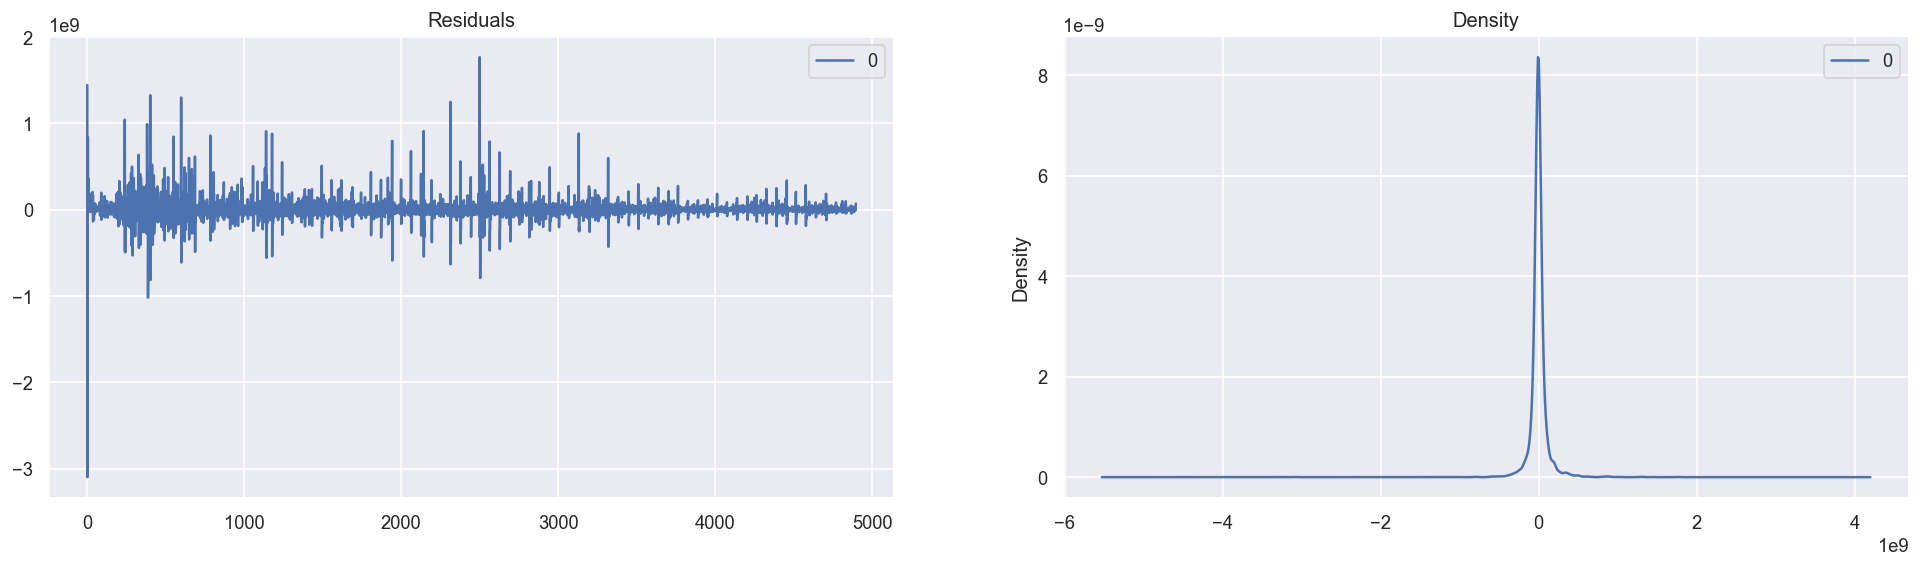

/Users/scohen6/projects/.venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


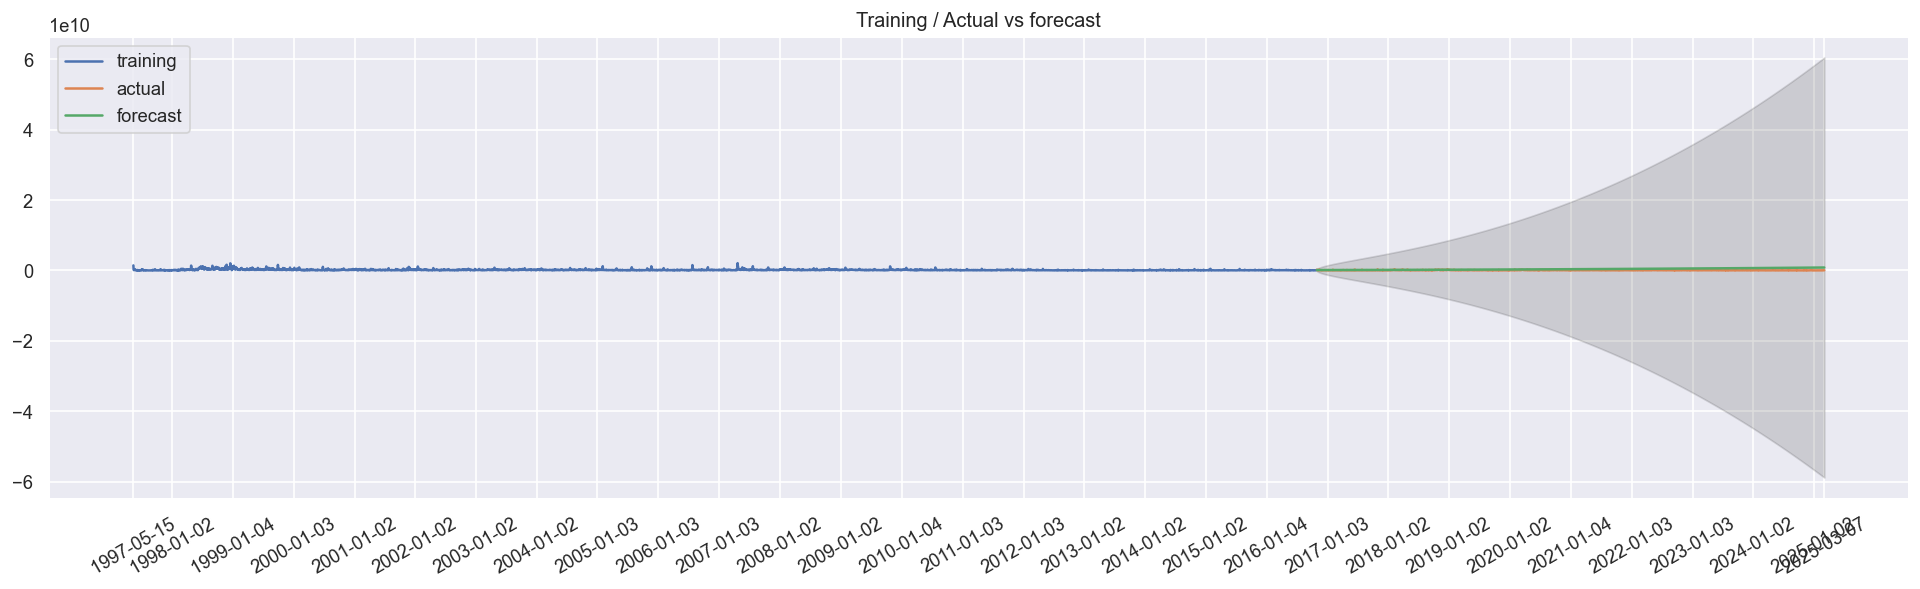

Train / Test based on:
order -> (3, 2, 1)
train_rate -> 0.7
                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                 4897
Model:                 ARIMA(3, 2, 1)   Log Likelihood              -97761.656
Date:                Sun, 09 Mar 2025   AIC                         195533.312
Time:                        00:27:39   BIC                         195565.792
Sample:                             0   HQIC                        195544.708
                               - 4897                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3250      0.008    -41.056      0.000      -0.341      -0.309
ar.L2         -0.2858      0.010    -29.188      0.000      -0.305     

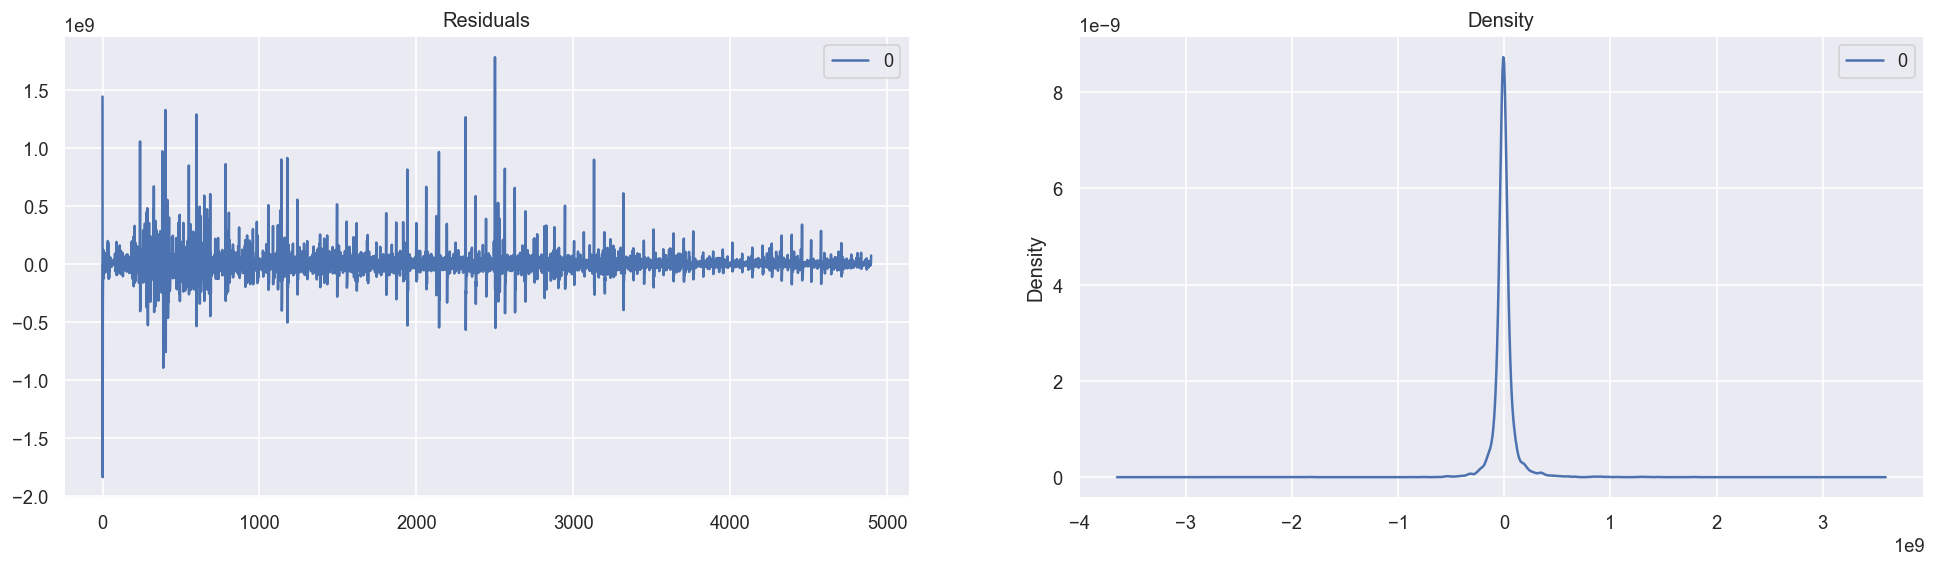

/Users/scohen6/projects/.venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


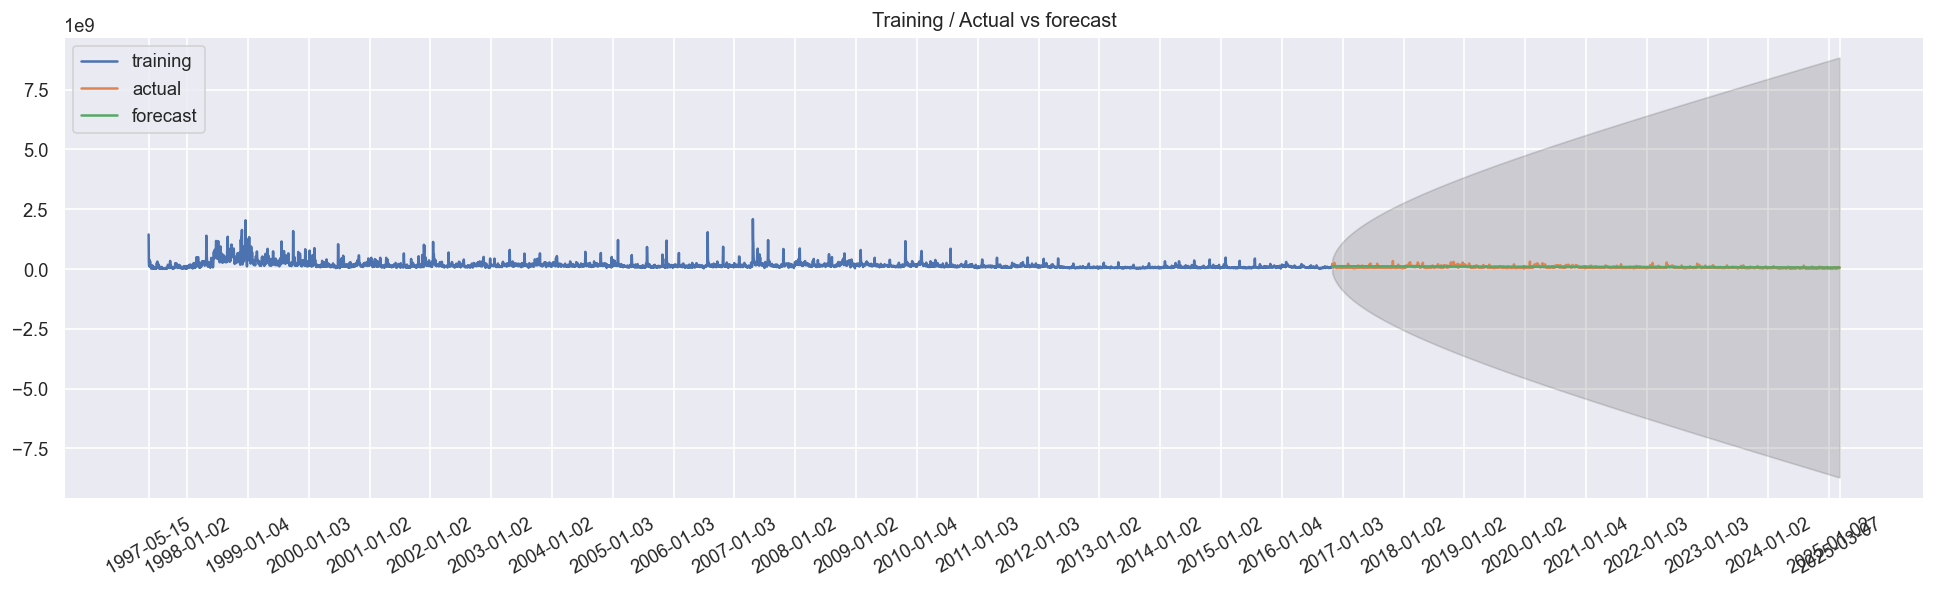

Train / Test based on:
order -> (3, 2, 1)
train_rate -> 0.8
                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                 5597
Model:                 ARIMA(3, 2, 1)   Log Likelihood             -111403.833
Date:                Sun, 09 Mar 2025   AIC                         222817.666
Time:                        00:27:41   BIC                         222850.814
Sample:                             0   HQIC                        222829.218
                               - 5597                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3246      0.007    -46.298      0.000      -0.338      -0.311
ar.L2         -0.2856      0.009    -32.940      0.000      -0.303     

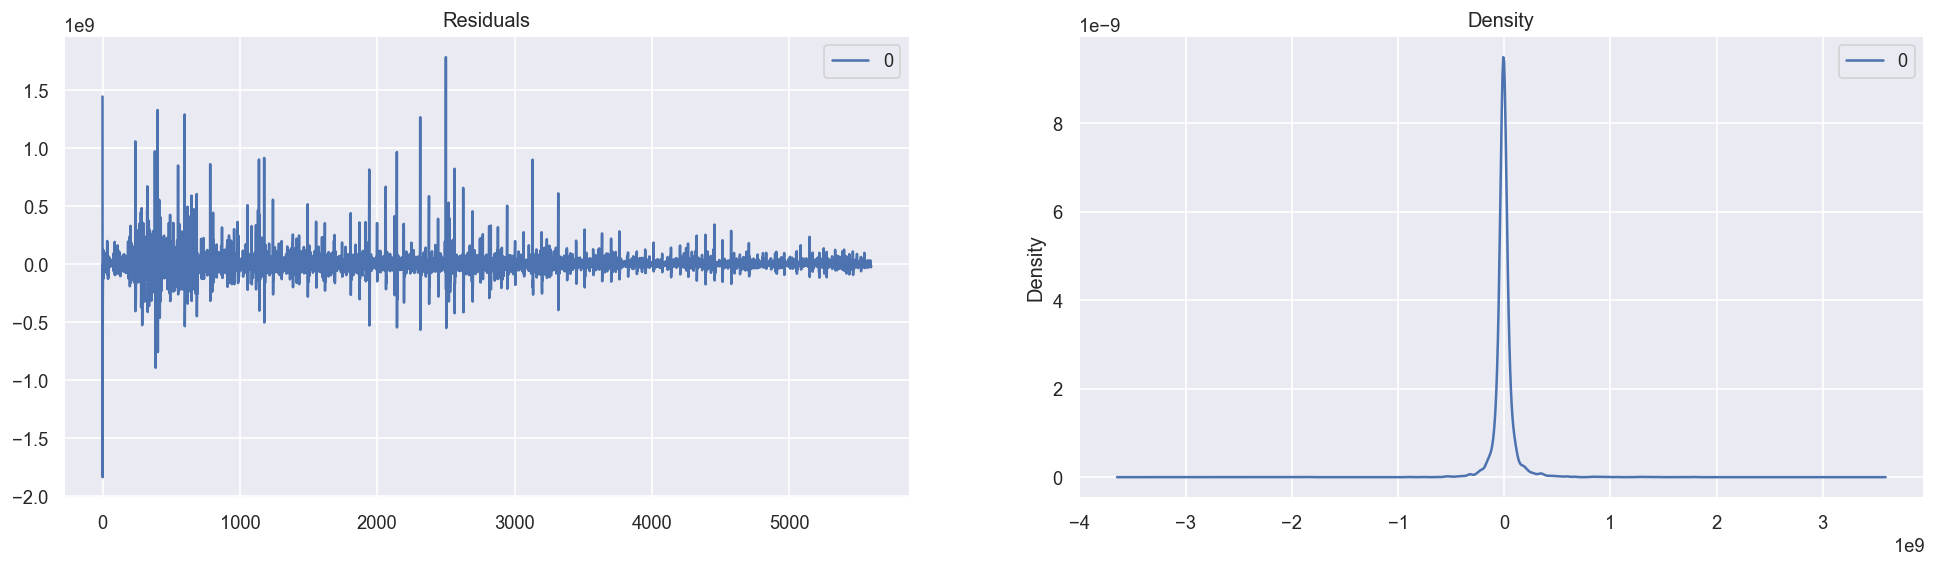

/Users/scohen6/projects/.venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


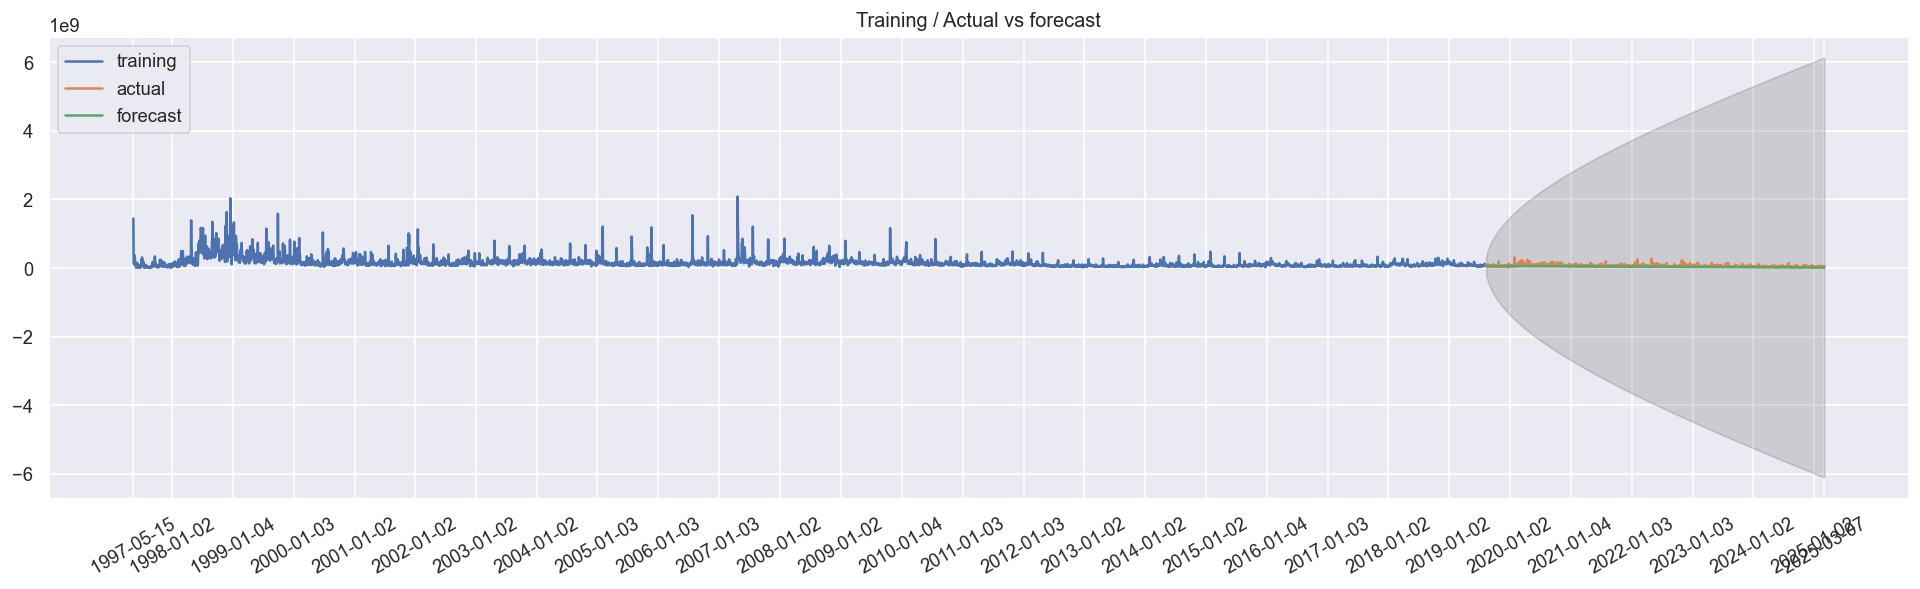

Train / Test based on:
order -> (3, 2, 1)
train_rate -> 0.9
                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                 6297
Model:                 ARIMA(3, 2, 1)   Log Likelihood             -125000.295
Date:                Sun, 09 Mar 2025   AIC                         250010.589
Time:                        00:27:44   BIC                         250044.327
Sample:                             0   HQIC                        250022.277
                               - 6297                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3246      0.006    -51.570      0.000      -0.337      -0.312
ar.L2         -0.2858      0.008    -36.749      0.000      -0.301     

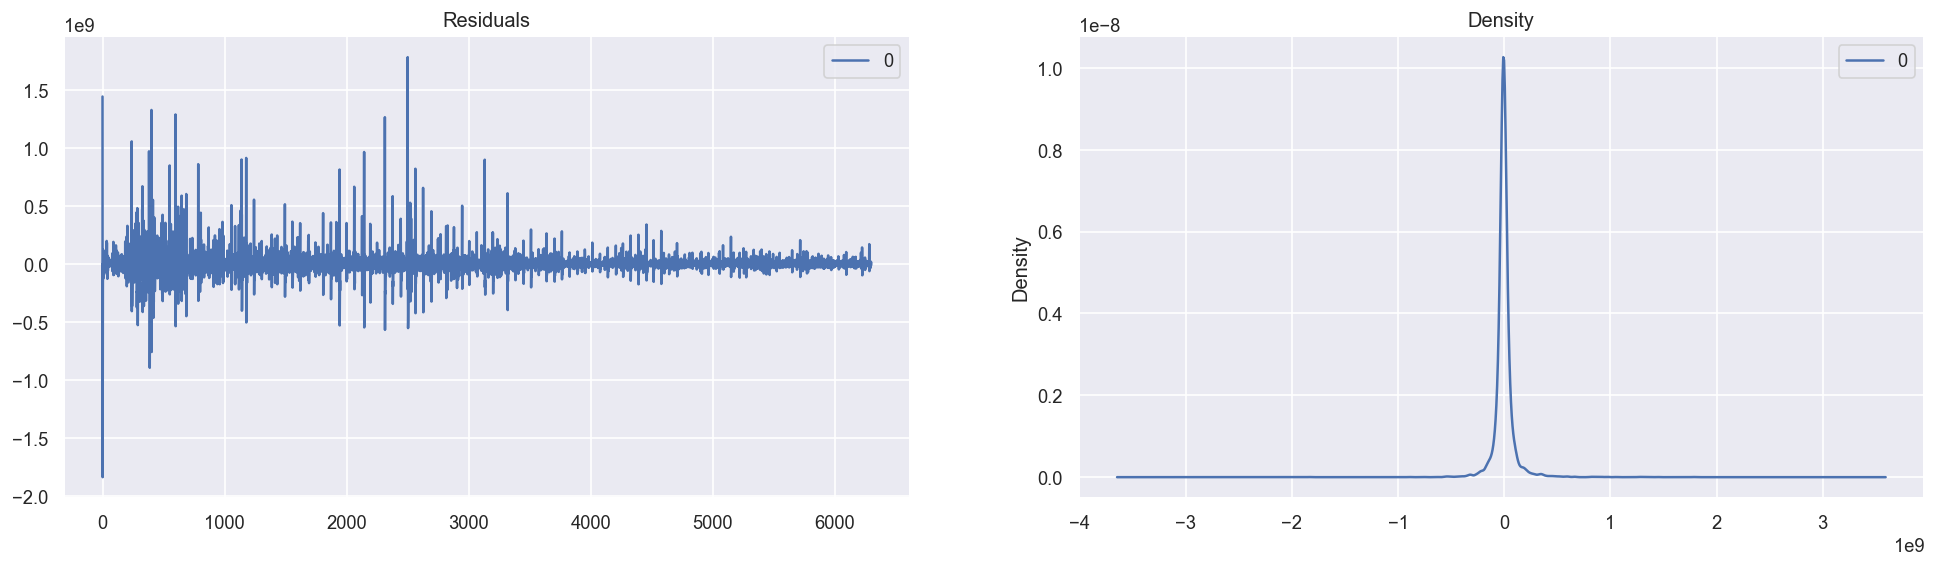

/Users/scohen6/projects/.venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


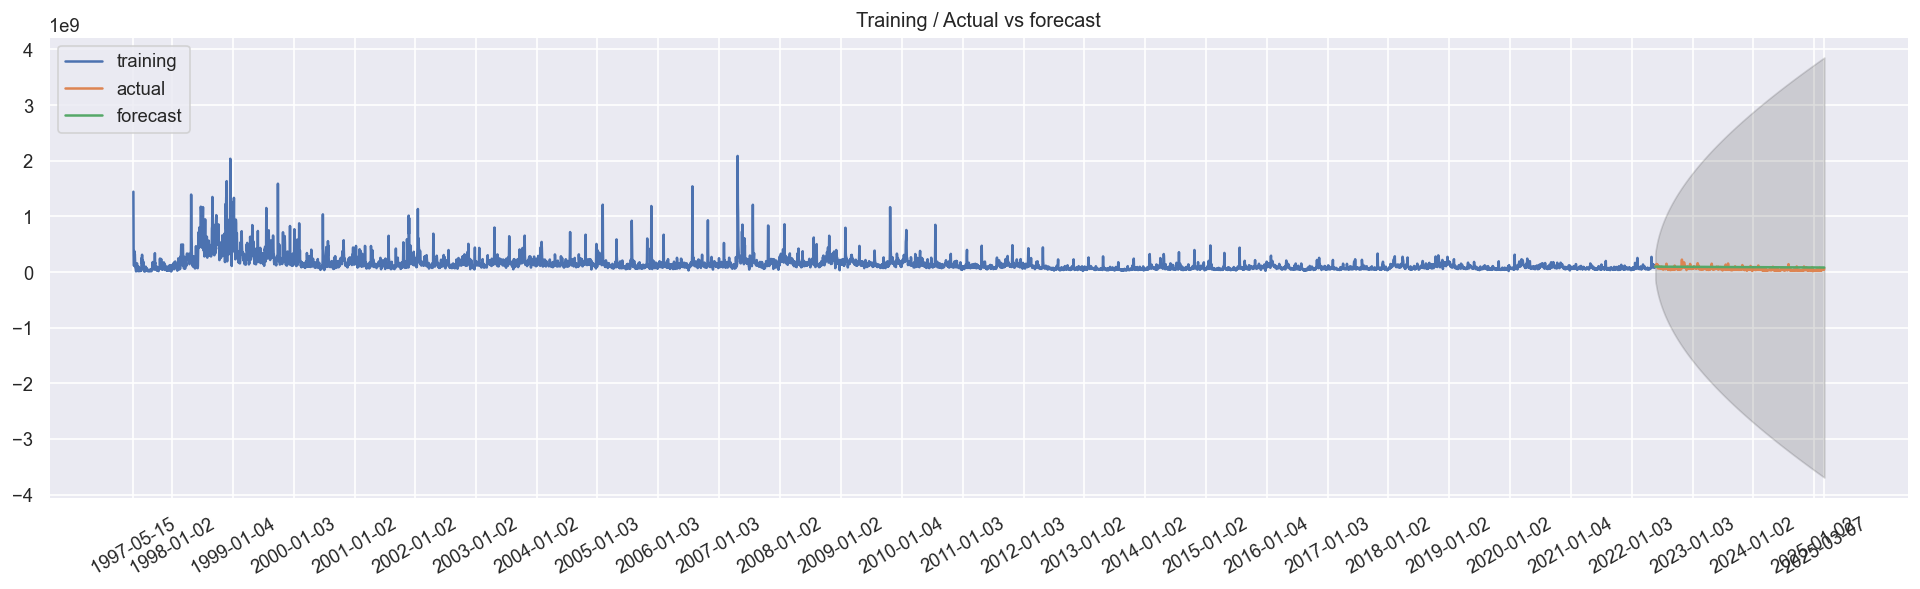

In [581]:
hyperparams = [{
    "order": (1, 1, 2),
    "train_rate": 0.7
},{
    "order": (1, 1, 1),
    "train_rate": 0.7
},{
    "order": (3, 3, 3),
     "train_rate": 0.7
},{
    "order": (3, 2 ,1),
     "train_rate": 0.7
},{
    "order": (3, 2 ,1),
     "train_rate": 0.8
},{
    "order": (3, 2 ,1),
     "train_rate": 0.9
}]

for dataset_type, dataset in datasets.items():
    date_labels = get_date_labels_amzn(dataset)

    #print(date_labels)
    
    plot_acf(dataset.value, f"Original Dataset -> {dataset_type}")
    print("==================================================================================================")
    for idx, hyperparam in enumerate(hyperparams):
        predicted_dataset = run_arima_train_test(dataset, hyperparam, date_labels)
        print("==================================================================================================")

# Use of generative AI
Please use the cell below to describe your use of generative AI in this assignment. 